# 1. Introducción

En esta práctica, participamos en una competición de predicción de precios de viviendas en Galicia organizada en la plataforma Kaggle. Nuestro objetivo es construir un flujo de trabajo completo de análisis de datos y modelado predictivo (desde la carga y exploración inicial hasta el preprocesado, la selección de características, el ajuste de hiperparámetros y la evaluación) con la métrica de error absoluto medio (MAE). 

El conjunto de datos, de naturaleza sintética, simula características reales de viviendas gallegas para que podamos abordar los desafíos habituales en proyectos de Machine Learning: tratar valores faltantes, codificar variables categóricas, gestionar datos atípicos y explotar relaciones no lineales entre las variables y el precio. 

Además, esta competición aporta el enfoque de otras perspectivas y metodologías distintas, lo que ayuda a conocer un rango más amplio de modos de implementación y enriquece nuestras propias estrategias de preprocesado, modelización y optimización.


# IMPORTS Y CONFIGURACIÓN

In [79]:
!pip install seaborn pandas matplotlib scikit-learn scipy xgboost missingno geopandas catboost lightgbm torch joblib statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import os
from scipy import stats
import missingno as msno  # Para visualizar datos faltantes
import geopandas as gpd  # Para análisis geoespacial
import time
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import joblib
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor



# Definir una semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configuraciones para visualización
#plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Configurar opciones de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.width', 200)

# 2. Descripción del conjunto de datos

El archivo de entrenamiento `train.csv` reúne 20 000 registros de viviendas sintéticas ubicadas en Galicia y 20 variables que describen cada propiedad, de las cuales 18 son características explicativas y dos identifican el registro (`id`) y el precio real en euros (`prezo_euros`). El propósito de este conjunto es alimentar nuestros modelos de regresión con información diversa —física, temporal, espacial, ambiental y cualitativa— para aprender patrones que permitan estimar con precisión el valor de mercado de cada vivienda.

## Atributos físicos y estructurales

- `superficie_interior_m2`: extensión útil interior. Tiene 18 993 valores no nulos (5 % de faltantes), media de 140 m² (σ ≈ 79 m²), rango de 10 a 1 015 m².
- `superficie_exterior_m2`: zona exterior (terraza o jardín). 18 973 registros completos (5,13 % de ausencias), media de 493 m² (σ ≈ 829 m²), muchos ceros.
- `numero_habitacions`: de 1 a 6 (sin faltantes), media ≈ 3,5.
- `numero_banos`: de 1 a 3 (sin faltantes), media ≈ 2,0.
- `numero_arboles_xardin`: de 0 a 19 (media ≈ 4,8; σ ≈ 6,3), 55 % de ceros.

## Datos temporales y climáticos

- `ano_construccion`: desde 1940 hasta 2024 (media ≈ 1982; σ ≈ 24). Picos en los 80–90 y tras 2010.
- `temperatura_media_mes_construccion`: de 0 °C a 30 °C (media ≈ 17,6 °C; σ ≈ 7,2 °C), sin valores ausentes.

## Localización geográfica y accesibilidad

- `lonxitude`: media ≈ –8,005; σ ≈ 0,75.
- `latitude`: media ≈ 42,801; σ ≈ 0,58.
- `distancia_centro_km`: 18 989 no nulos; media ≈ 25,8 km; máximo ≈ 199 km.
- `distancia_escola_km`: 18 979 no nulos; media ≈ 10,35 km; máximo ≈ 108 km. Correlación moderada con la distancia al centro (r ≈ 0,60).

## Entorno social y variables de riesgo

- `indice_criminalidade`: 19 012 observaciones completas (5 % ausentes), varía de 0 a 1,06 (media ≈ 0,33; σ ≈ 0,20), correlación negativa con el precio (r ≈ –0,20).
- `acceso_transporte_publico`: categórica — “Bo” (11 825), “Regular” (5 983), “Malo” (2 192).

## Variables cualitativas

- `tipo_edificacion`: apartamentos (9 873), casas unifamiliares (6 066), chalets adosados (4 061).
- `calidade_materiais`: “Alta” (6 061), “Media” (9 920), “Baixa” (4 019). Correlación ordinal fuerte con el precio (r ≈ 0,70).
- `eficiencia_enerxetica`: categorías de “A” a “G”, mayoría en C (4 013) y D (3 933).
- `orientacion`: Norte (5 040), Sur (4 997), Este (4 996), Oeste (4 967).
- `cor_favorita_propietario`: diez colores, más frecuentes: Verde (3 374), Branco (3 361), Amarelo (3 350). Correlaciones nulas con el precio.

In [16]:
# =============================================================================
# 1.1 CARGA DE DATOS
# =============================================================================

# Cargar los conjuntos de datos
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f"Dimensiones del conjunto de entrenamiento: {train_data.shape}")
print(f"Dimensiones del conjunto de prueba: {test_data.shape}")

# Verificar las primeras filas del conjunto de entrenamiento
print("\nPrimeras filas del conjunto de entrenamiento:")
train_data.head()

Dimensiones del conjunto de entrenamiento: (20000, 20)
Dimensiones del conjunto de prueba: (10000, 20)

Primeras filas del conjunto de entrenamiento:


id  superficie_interior_m2  superficie_exterior_m2  numero_habitacions  numero_banos  ano_construccion  lonxitude  latitude  temperatura_media_mes_construccion tipo_edificacion  \
0  25521                   44.96                    0.00                   1             2              1947      -8.17     43.20                               24.75      Apartamento   
1   4843                   93.55                   87.26                   2             2              1977      -7.23     43.60                               14.06      Apartamento   
2  27734                  273.64                  187.29                   1             1              1996      -8.40     42.25                               12.27   Chalet adosado   
3  22142                  171.82                   54.89                   4             2              1996      -6.81     43.15                               11.61   Chalet adosado   
4  14748                     NaN                 2153.49                   1             1              1990      -8.76     42.92                               10.04             Casa   

  calidade_materiais cor_favorita_propietario  distancia_centro_km  distancia_escola_km  indice_criminalidade acceso_transporte_publico orientacion eficiencia_enerxetica  numero_arboles_xardin  \
0              Media                     Azul                23.68                 2.75                  0.35                        Bo       Norte                     C                      0   
1               Alta                    Verde                  NaN                16.67                  0.44                        Bo        Este                     C                      0   
2              Media                   Branco                29.44                18.96                  0.47                   Regular        Este                     C                     10   
3               Alta                 Vermello                53.31                 1.96                  0.35                        Bo        Este                     G                      3   
4              Baixa                    Verde                70.20                 4.72                  0.09                        Bo       Oeste                     G                     12   

   prezo_euros  
0        51938  
1        76891  
2       261441  
3       247821  
4       400645

In [17]:
# =============================================================================
# 2.1 EXPLORACIÓN INICIAL | NULLS y TIPOS
# =============================================================================

# Información general sobre los tipos de datos
print("\nTipos de datos en el conjunto de entrenamiento:")
train_data.info()

# Estadísticas descriptivas para variables numéricas
print("\nEstadísticas descriptivas para variables numéricas:")
train_data.describe()

# Estadísticas descriptivas para variables categóricas
print("\nEstadísticas descriptivas para variables categóricas:")
train_data.describe(include=['object'])

display(train_data.head())


Tipos de datos en el conjunto de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  20000 non-null  int64  
 1   superficie_interior_m2              18993 non-null  float64
 2   superficie_exterior_m2              18973 non-null  float64
 3   numero_habitacions                  20000 non-null  int64  
 4   numero_banos                        20000 non-null  int64  
 5   ano_construccion                    20000 non-null  int64  
 6   lonxitude                           20000 non-null  float64
 7   latitude                            20000 non-null  float64
 8   temperatura_media_mes_construccion  20000 non-null  float64
 9   tipo_edificacion                    20000 non-null  object 
 10  calidade_materiais                  20000 non-null  objec

id  superficie_interior_m2  superficie_exterior_m2  numero_habitacions  numero_banos  ano_construccion  lonxitude  latitude  temperatura_media_mes_construccion tipo_edificacion  \
0  25521                   44.96                    0.00                   1             2              1947      -8.17     43.20                               24.75      Apartamento   
1   4843                   93.55                   87.26                   2             2              1977      -7.23     43.60                               14.06      Apartamento   
2  27734                  273.64                  187.29                   1             1              1996      -8.40     42.25                               12.27   Chalet adosado   
3  22142                  171.82                   54.89                   4             2              1996      -6.81     43.15                               11.61   Chalet adosado   
4  14748                     NaN                 2153.49                   1             1              1990      -8.76     42.92                               10.04             Casa   

  calidade_materiais cor_favorita_propietario  distancia_centro_km  distancia_escola_km  indice_criminalidade acceso_transporte_publico orientacion eficiencia_enerxetica  numero_arboles_xardin  \
0              Media                     Azul                23.68                 2.75                  0.35                        Bo       Norte                     C                      0   
1               Alta                    Verde                  NaN                16.67                  0.44                        Bo        Este                     C                      0   
2              Media                   Branco                29.44                18.96                  0.47                   Regular        Este                     C                     10   
3               Alta                 Vermello                53.31                 1.96                  0.35                        Bo        Este                     G                      3   
4              Baixa                    Verde                70.20                 4.72                  0.09                        Bo       Oeste                     G                     12   

   prezo_euros  
0        51938  
1        76891  
2       261441  
3       247821  
4       400645

In [18]:
# =============================================================================
# 2.2 VERIFICACIÓN DE DUPLICADOS
# =============================================================================

# Verificar filas duplicadas en el conjunto de entrenamiento
duplicados_train = train_data.duplicated().sum()
print(f"\nCantidad de filas duplicadas en el conjunto de entrenamiento: {duplicados_train}")



Cantidad de filas duplicadas en el conjunto de entrenamiento: 0



Análisis de valores faltantes:
                        Missing Values  Percent Missing
superficie_exterior_m2            1027             5.13
distancia_escola_km               1021             5.10
distancia_centro_km               1011             5.05
superficie_interior_m2            1007             5.04
indice_criminalidade               988             4.94


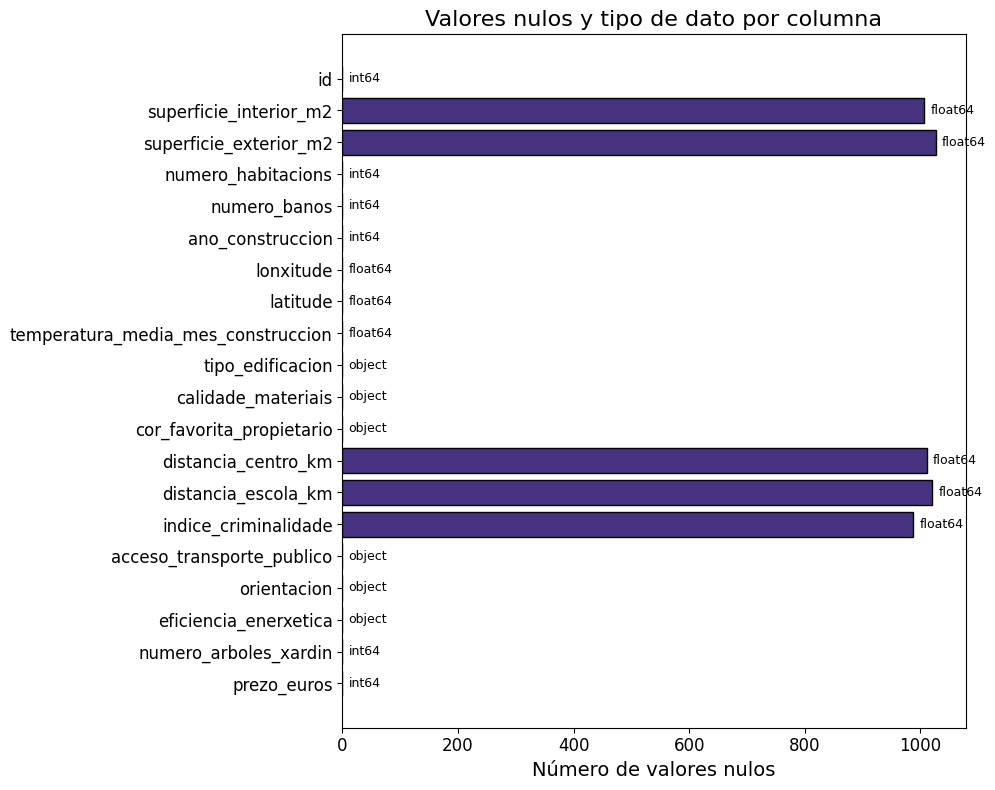

In [19]:
# =============================================================================
# 3. ANÁLISIS DE VALORES FALTANTES
# =============================================================================

# Calcular la cantidad de valores faltantes por columna
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_percent = (train_data.isnull().sum() / train_data.shape[0] * 100).sort_values(ascending=False)

missing_df = pd.DataFrame({'Missing Values': missing_values, 
                          'Percent Missing': missing_percent})
print("\nAnálisis de valores faltantes:")
print(missing_df[missing_df['Missing Values'] > 0])

df = train_data
# Cálculo de nulos y tipos
null_counts = df.isnull().sum()
dtypes = df.dtypes

# Preparar la figura
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(null_counts.index, null_counts.values, edgecolor='black')

# Anotar el tipo de dato junto a cada barra
for bar, dtype in zip(bars, dtypes):
    ax.text(bar.get_width() + max(null_counts.values)*0.01,  # un poquito a la derecha
            bar.get_y() + bar.get_height() / 2,
            str(dtype),
            va='center', fontsize= 9)

# Etiquetas y estilo
ax.set_xlabel('Número de valores nulos')
ax.set_title('Valores nulos y tipo de dato por columna')
ax.invert_yaxis()  # Opcional: para que la primera columna quede arriba
plt.tight_layout()

# Guardar o mostrar
plt.savefig('figura_nulos_tipos.png', dpi=300)
plt.show()

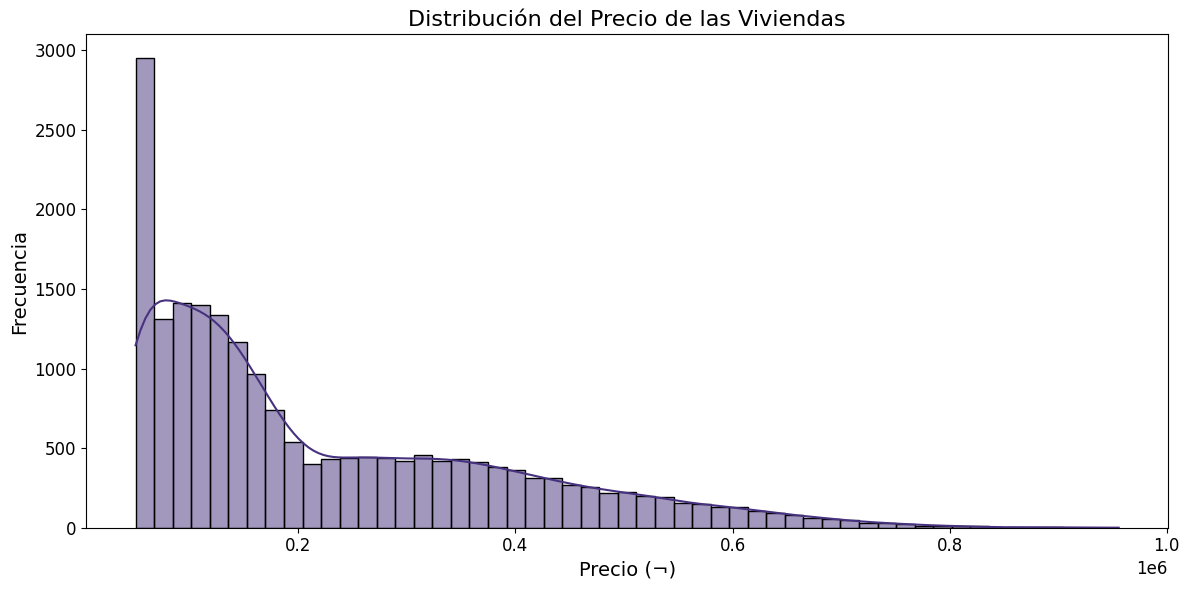


Estadísticas de la variable objetivo (prezo_euros):
count    20000.00
mean    223402.81
std     166395.70
min      50000.00
25%      93345.75
50%     159407.50
75%     329635.00
max     955855.00
Name: prezo_euros, dtype: float64


In [20]:
# =============================================================================
# 4. ANÁLISIS DE LA VARIABLE OBJETIVO
# =============================================================================

# Distribución del precio
plt.figure(figsize=(12, 6))
sns.histplot(train_data['prezo_euros'], kde=True)
plt.title('Distribución del Precio de las Viviendas', fontsize=16)
plt.xlabel('Precio (¬)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.tight_layout()
#plt.savefig('precio_distribucion.png')
plt.show()


# Estadísticas básicas del precio
precio_stats = train_data['prezo_euros'].describe()
print("\nEstadísticas de la variable objetivo (prezo_euros):")
print(precio_stats)

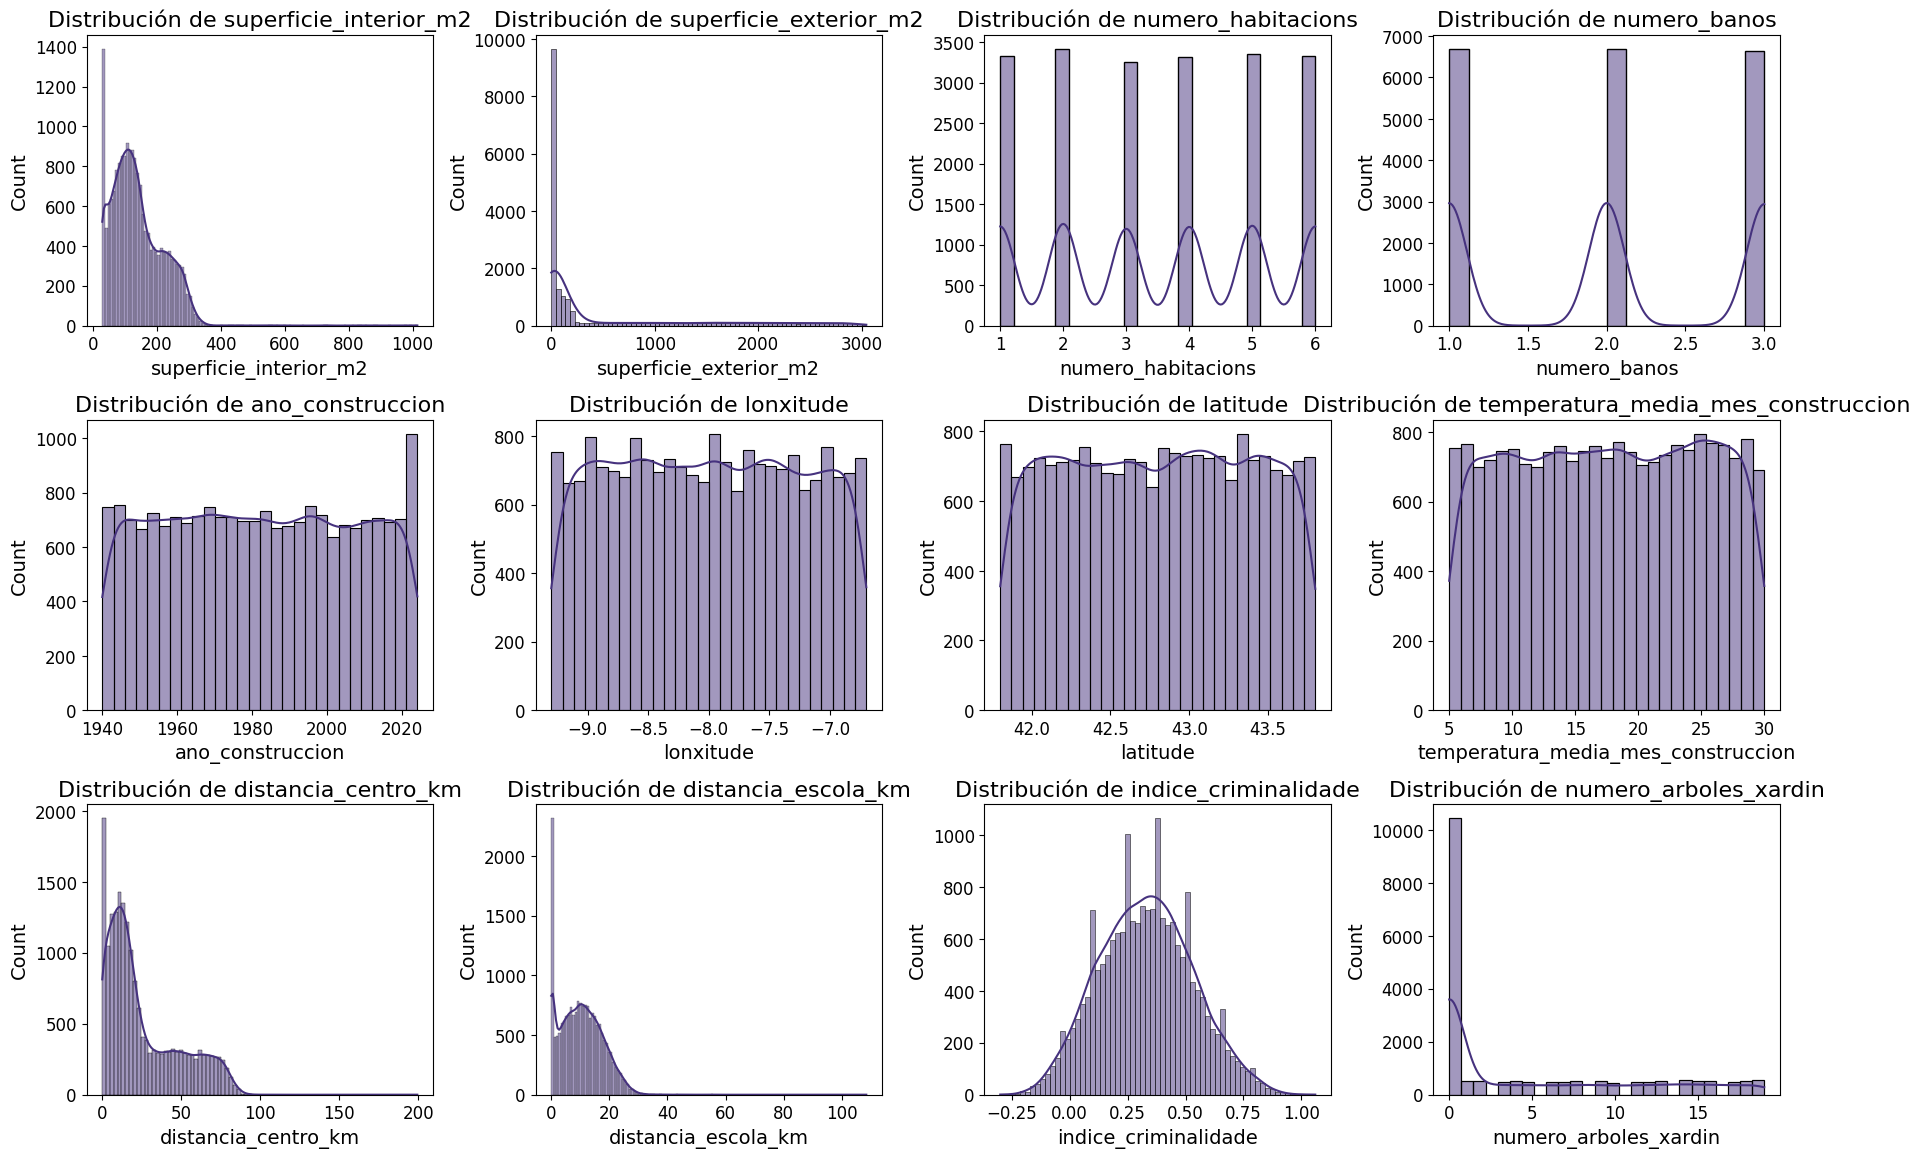

distancia_centro_km: 0 filas con valor 0
distancia_escola_km: 0 filas con valor 0
superficie_interior_m2: 0 filas con valor 0
superficie_exterior_m2: 4854 filas con valor 0


In [21]:
# =============================================================================
# 5. ANÁLISIS DE VARIABLES NUMÉRICAS
# =============================================================================

# Identificar variables numéricas (excluyendo el ID y la variable objetivo)
numeric_features = train_data.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [f for f in numeric_features if f not in ['id', 'prezo_euros']]

# Histogramas para variables numéricas
plt.figure(figsize=(18, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 4, i)
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribución de {feature}')
    plt.tight_layout()
#plt.savefig('numeric_features_distribution.png')
plt.show()

# Columnas a analizar
cols = [
    'distancia_centro_km',
    'distancia_escola_km',
    'superficie_interior_m2',
    'superficie_exterior_m2'
]

# Cálculo del número de filas con valor 0 en cada columna
zero_counts = train_data[cols].apply(lambda s: (s == 0).sum())

# Mostrar resultados
for col, count in zero_counts.items():
    print(f"{col}: {count} filas con valor 0")

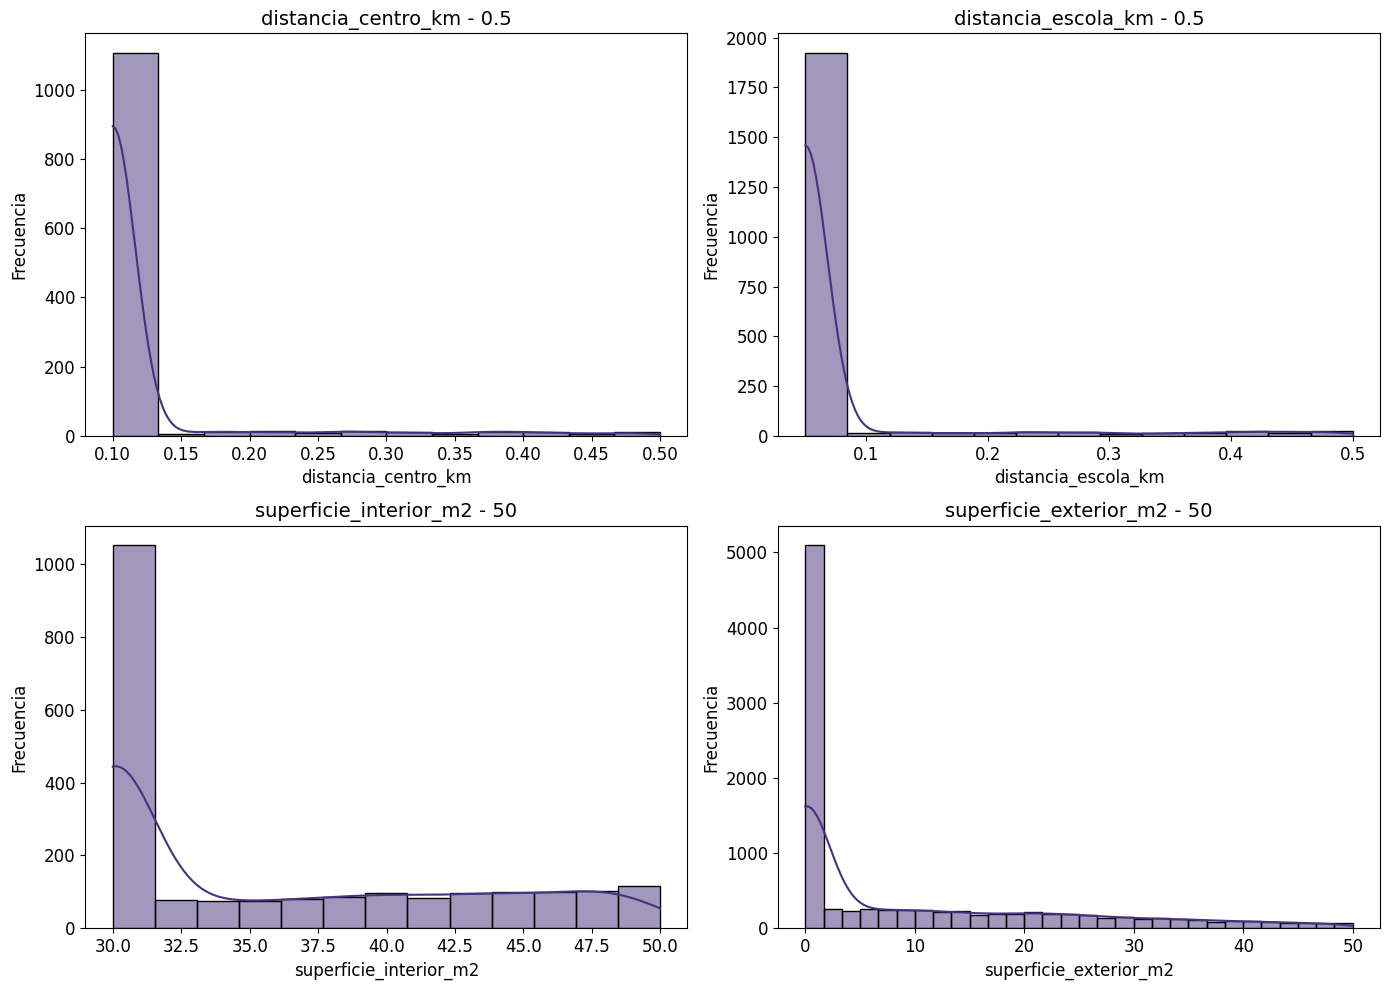

In [22]:

# Definir umbrales por columna
thresholds = {
    'distancia_centro_km': 0.5,
    'distancia_escola_km': 0.5,
    'superficie_interior_m2': 50,
    'superficie_exterior_m2': 50
}

# Crear figura con subplots 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (col, umbral) in zip(axes, thresholds.items()):
    # Tomar datos, eliminar nulls y valores por encima del umbral
    data = train_data[col].dropna()
    data = data[data <= umbral]
    
    # Histograma
    sns.histplot(data, kde=True, ax=ax)
    ax.set_title(f'{col} - {umbral}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout()
# plt.savefig('numeric_features_thresholded.png', dpi=300)
plt.show()


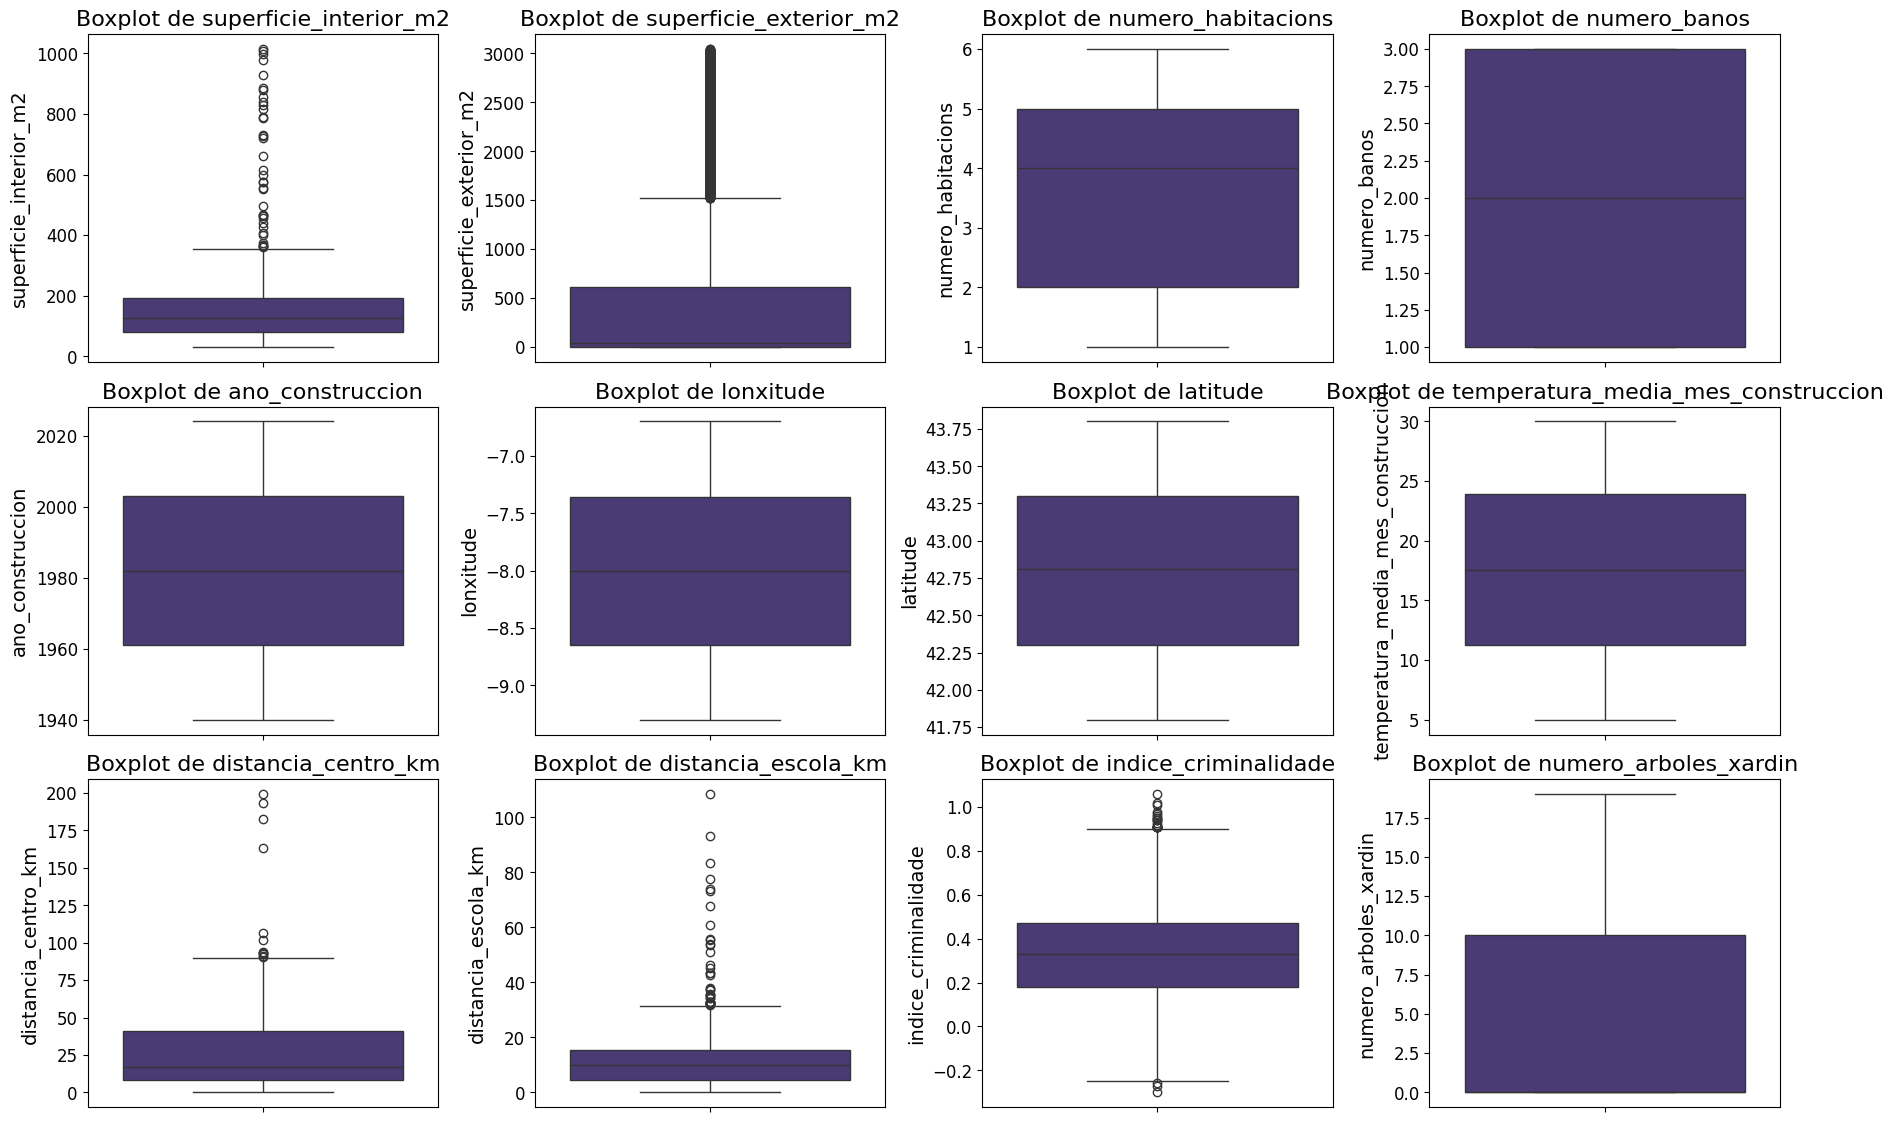

In [23]:

# Boxplots para variables numéricas
plt.figure(figsize=(18, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=train_data[feature])
    plt.title(f'Boxplot de {feature}')
    plt.tight_layout()
#plt.savefig('numeric_features_boxplot.png')
plt.show()



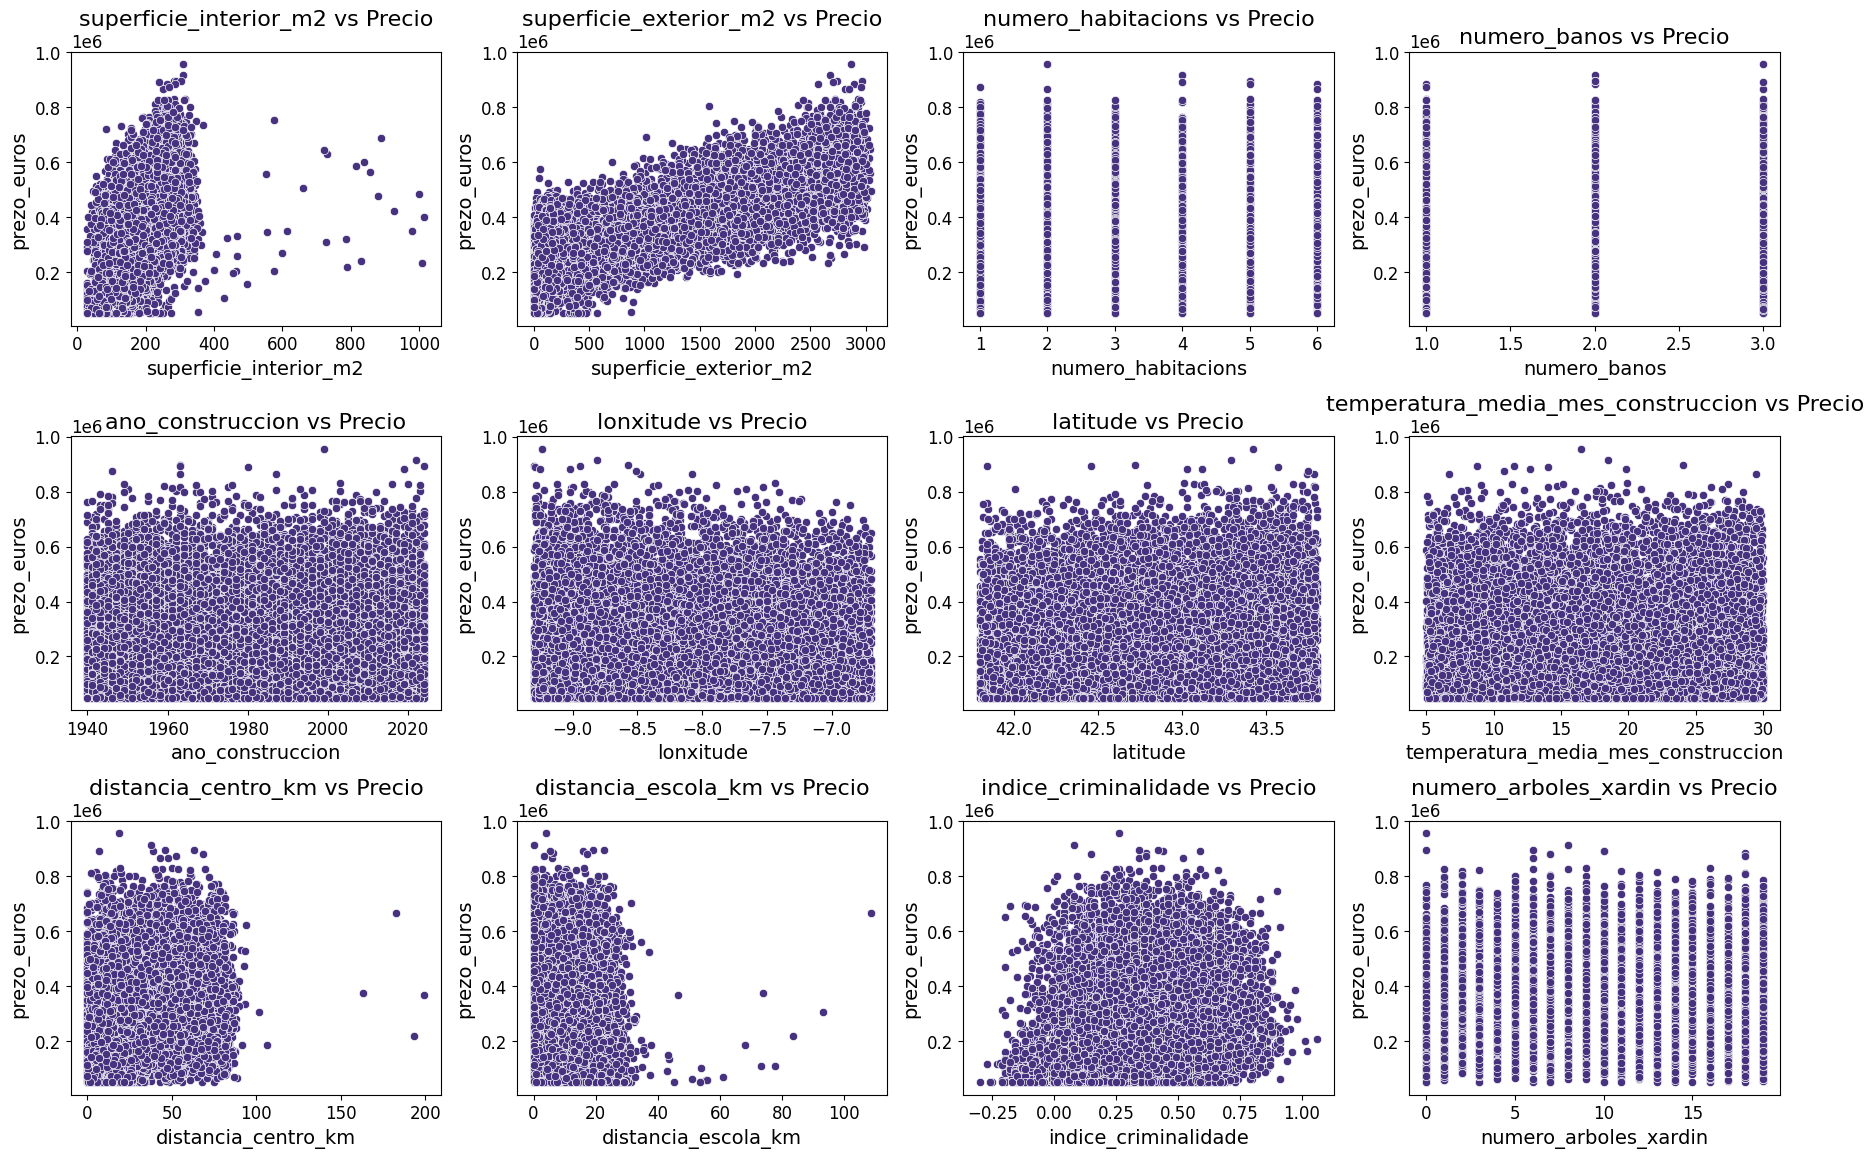

In [24]:
# Scatter plots con la variable objetivo
plt.figure(figsize=(18, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 4, i)
    sns.scatterplot(x=train_data[feature], y=train_data['prezo_euros'])
    plt.title(f'{feature} vs Precio')
    plt.tight_layout()
#plt.savefig('numeric_features_vs_precio.png')
plt.show()

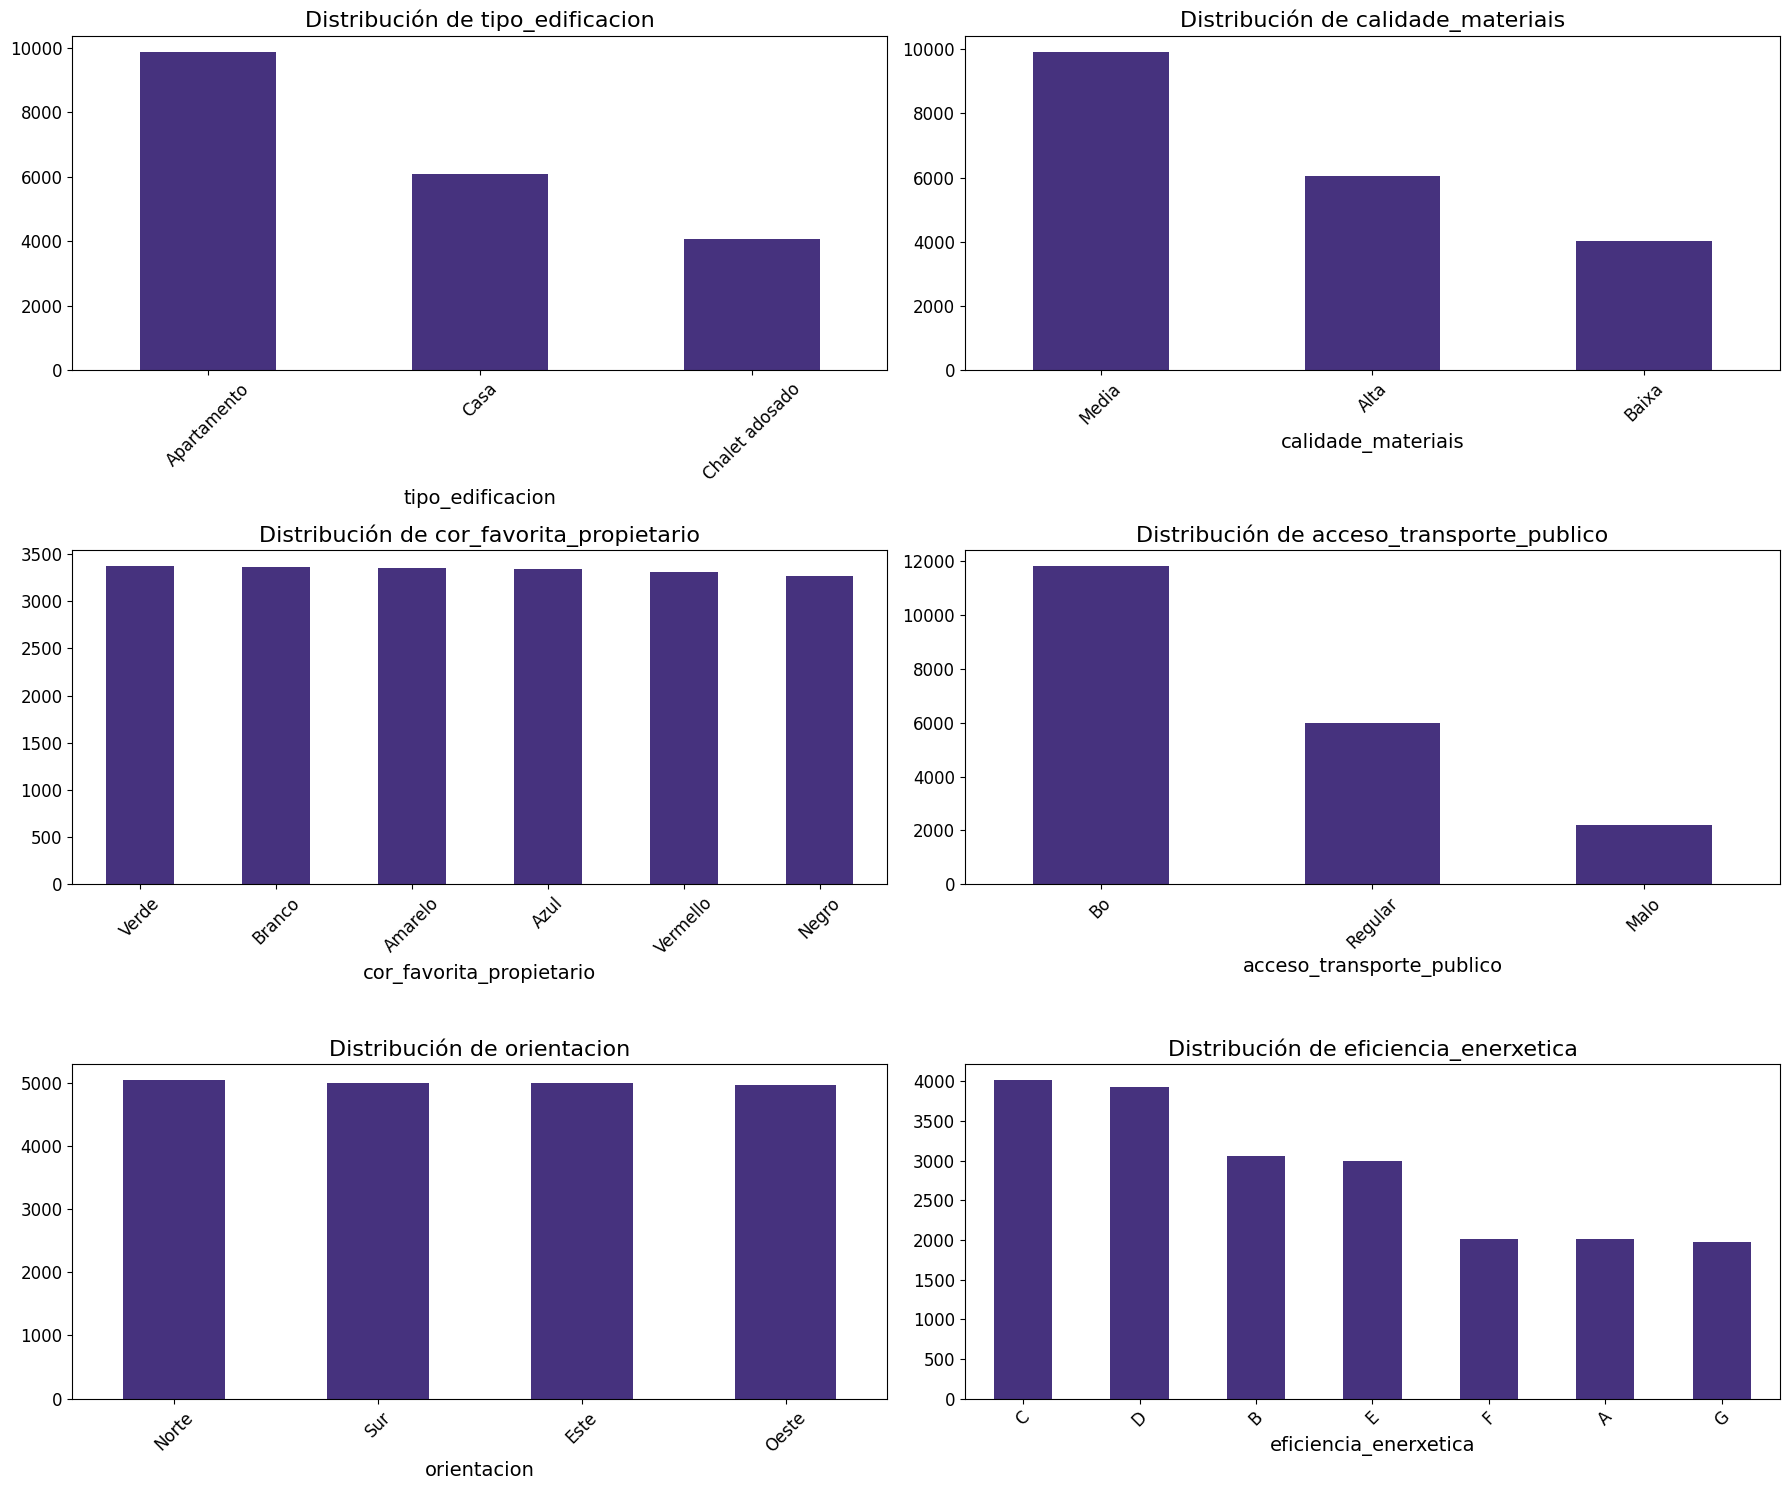

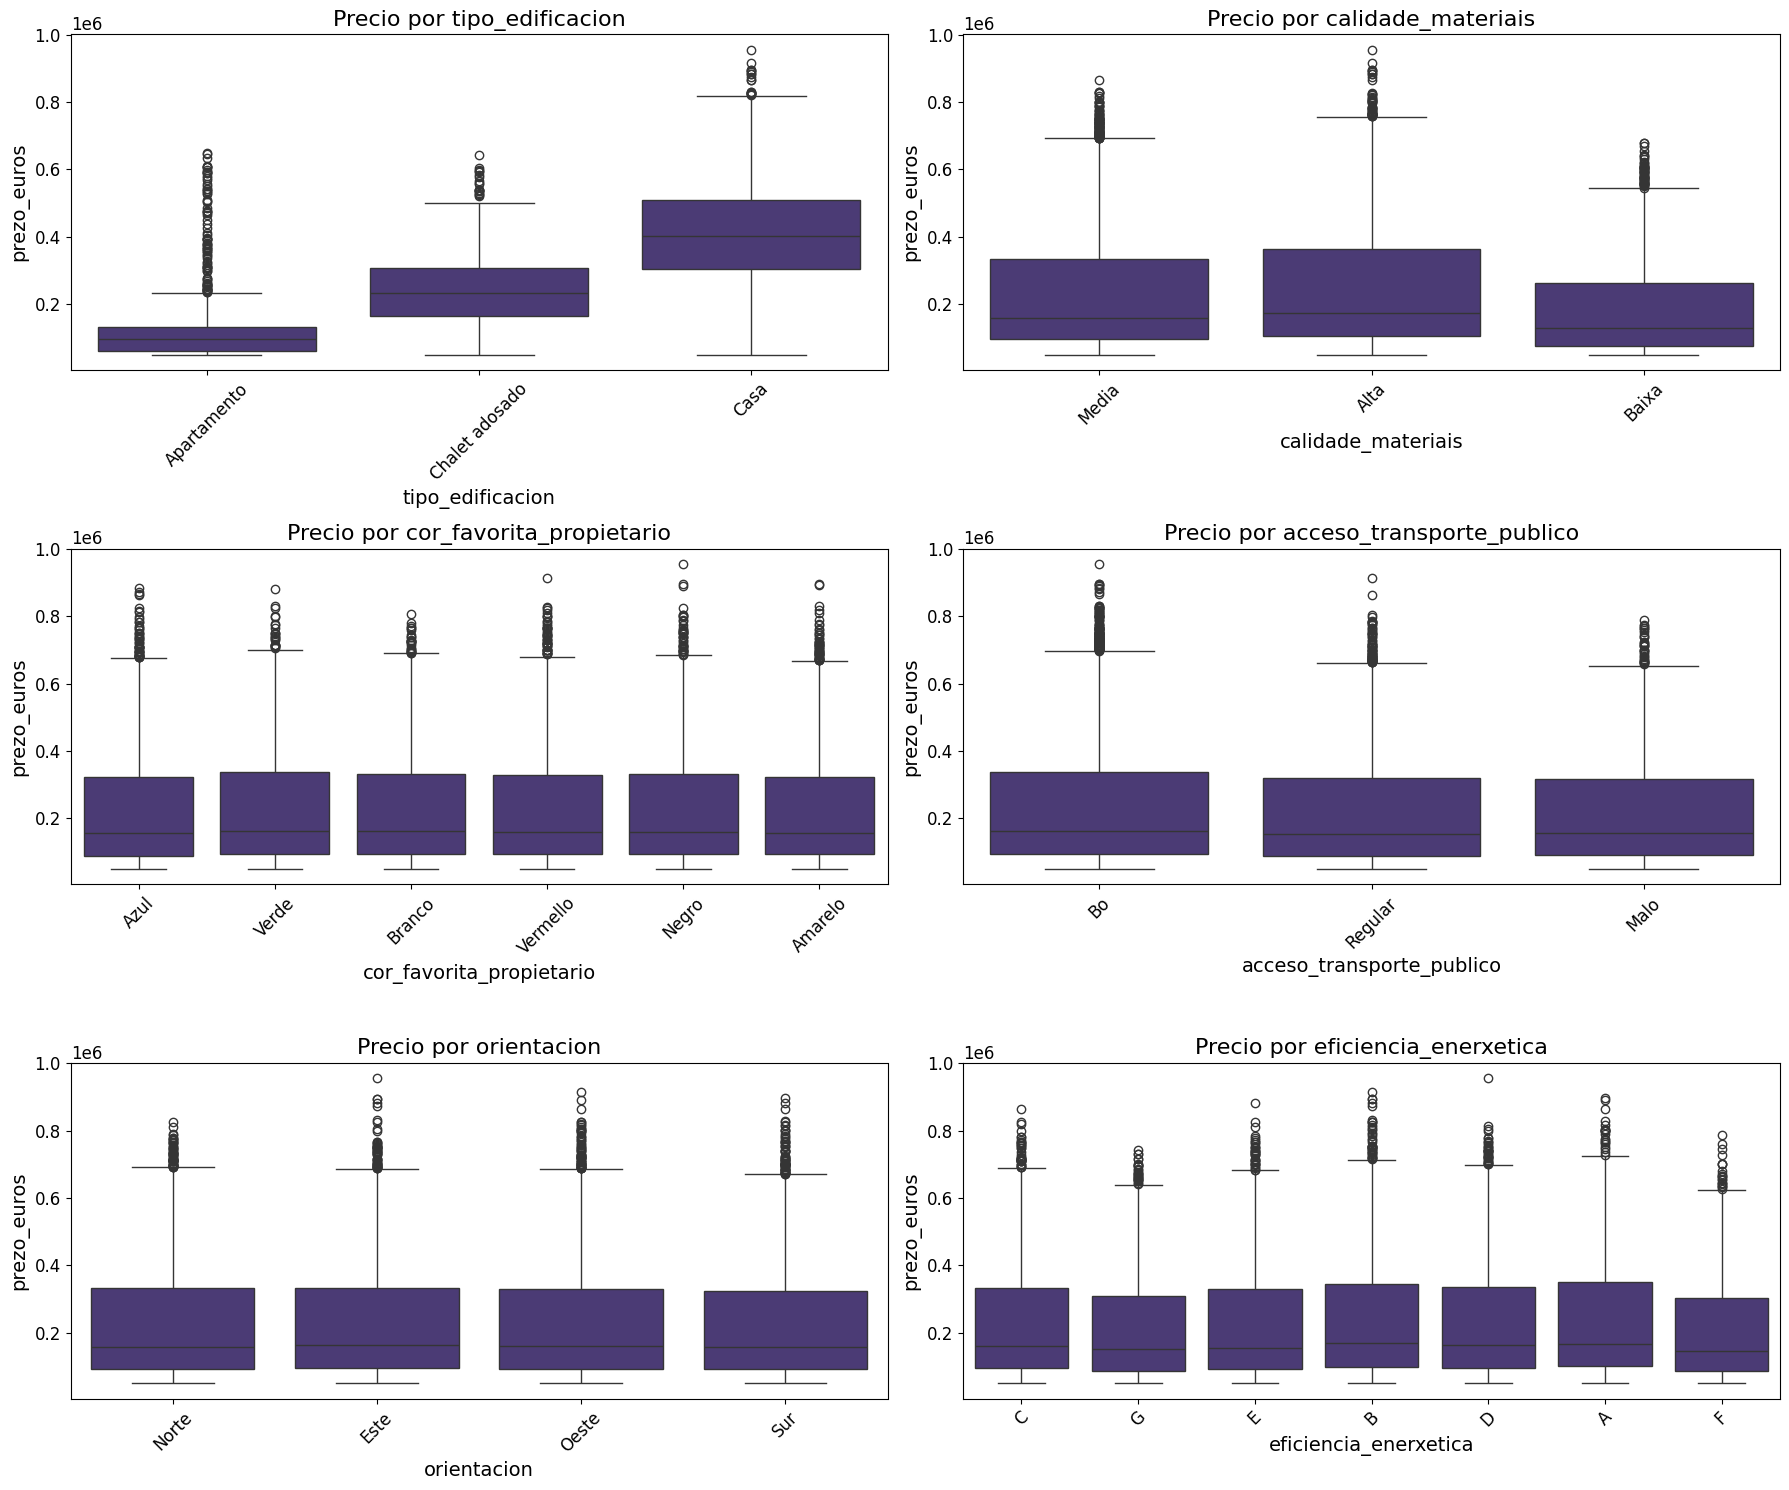

In [25]:
# =============================================================================
# 6. ANÁLISIS DE VARIABLES CATEGÓRICAS
# =============================================================================

# Identificar variables categóricas
categorical_features = train_data.select_dtypes(include=['object']).columns

# Bar plots para variables categóricas
plt.figure(figsize=(18, 15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    train_data[feature].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
#plt.savefig('categorical_features_distribution.png')
plt.show()

# Boxplots de precio por categoría
plt.figure(figsize=(18, 15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=train_data[feature], y=train_data['prezo_euros'])
    plt.title(f'Precio por {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
#plt.savefig('precio_vs_categorical_features.png')
plt.show()

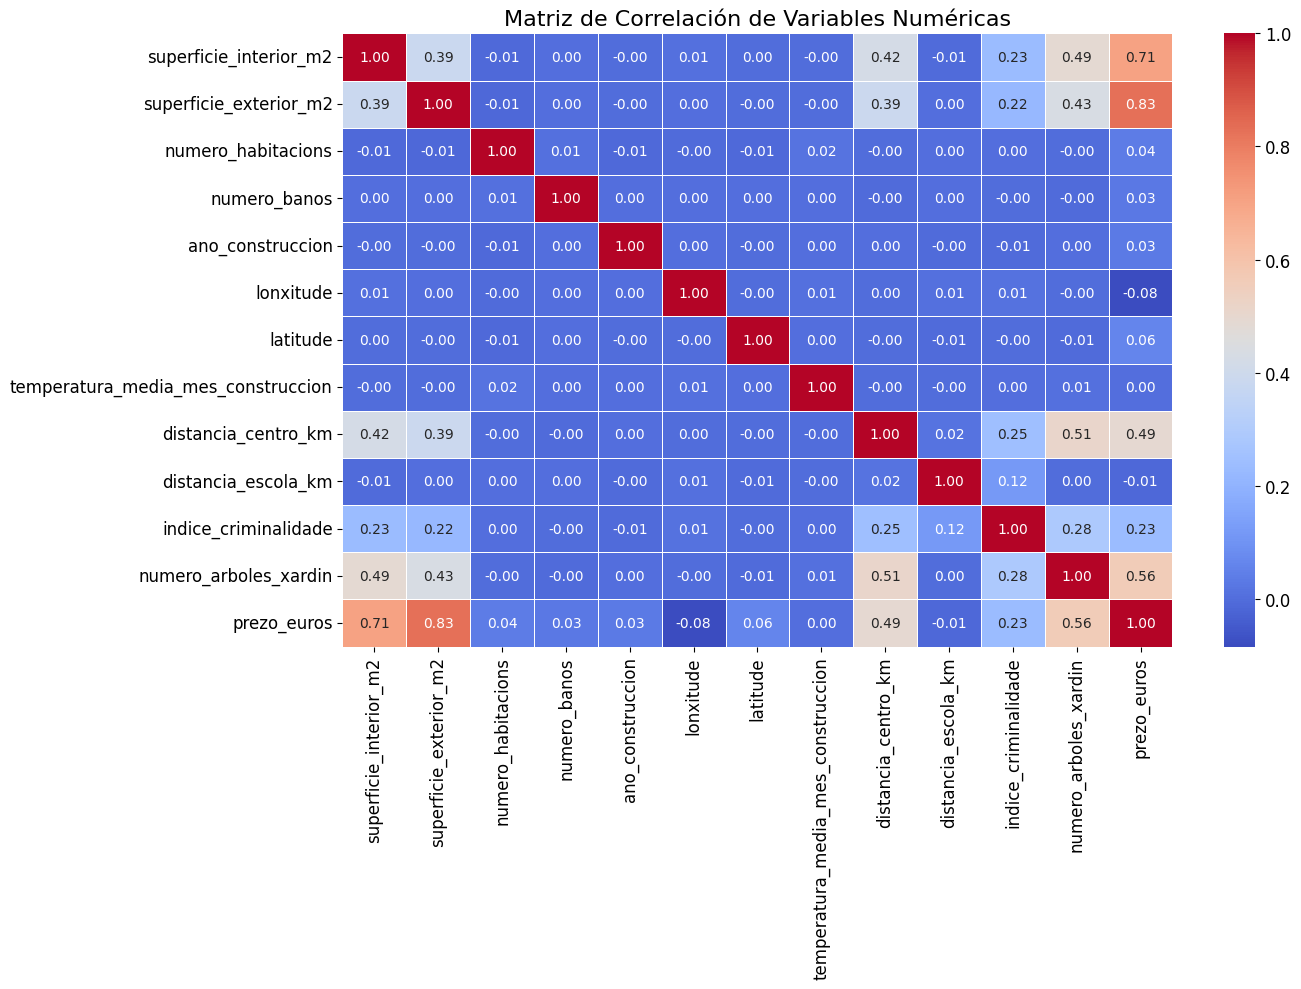


Correlaciones con la variable objetivo (prezo_euros):
prezo_euros                           1.00
superficie_exterior_m2                0.83
superficie_interior_m2                0.71
numero_arboles_xardin                 0.56
distancia_centro_km                   0.49
indice_criminalidade                  0.23
latitude                              0.06
numero_habitacions                    0.04
ano_construccion                      0.03
numero_banos                          0.03
temperatura_media_mes_construccion    0.00
distancia_escola_km                  -0.01
lonxitude                            -0.08
Name: prezo_euros, dtype: float64


In [26]:
# =============================================================================
# 7.1 MATRIZ DE CORRELACIÓN VARIABLES NUMERICAS
# =============================================================================

# Calcular matriz de correlación para variables numéricas
correlation_matrix = train_data[numeric_features + ['prezo_euros']].corr()

# Visualizar matriz de correlación
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16)
plt.tight_layout()
#plt.savefig('correlation_matrix.png')
plt.show()

# Top correlaciones con la variable objetivo
precio_correlations = correlation_matrix['prezo_euros'].sort_values(ascending=False)
print("\nCorrelaciones con la variable objetivo (prezo_euros):")
print(precio_correlations)

/tmp/ipykernel_27106/1175268588.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_tabla['sum_sq'][0] / anova_tabla['sum_sq'].sum()
/tmp/ipykernel_27106/1175268588.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_tabla['sum_sq'][0] / anova_tabla['sum_sq'].sum()
/tmp/ipykernel_27106/1175268588.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_sq = anova_tabla['sum_sq'][0] / anova_tabla['sum_sq'

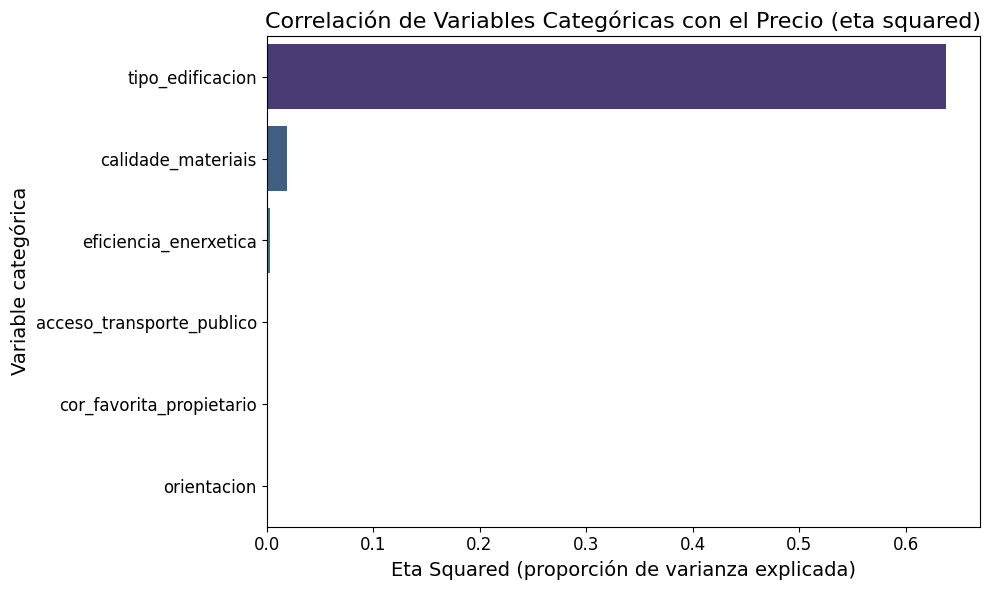


Correlación de variables categóricas con 'prezo_euros' (eta squared):
                           Eta Squared
tipo_edificacion                  0.64
calidade_materiais                0.02
eficiencia_enerxetica             0.00
acceso_transporte_publico         0.00
cor_favorita_propietario          0.00
orientacion                       0.00


In [27]:
# =============================================================================
# 7.2 CORRELACIÓN ENTRE VARIABLES CATEGÓRICAS Y PRECIO (·² - Eta Squared)
# =============================================================================

# Función para calcular eta squared (proporción de varianza explicada)
def calcular_eta_squared(cat_col, target_col='prezo_euros'):
    modelo = ols(f"{target_col} ~ C({cat_col})", data=train_data).fit()
    anova_tabla = sm.stats.anova_lm(modelo, typ=2)
    eta_sq = anova_tabla['sum_sq'][0] / anova_tabla['sum_sq'].sum()
    return eta_sq

# Calcular ·² para cada variable categórica
eta_squared_resultados = {}

for col in categorical_features:
    try:
        eta_squared_resultados[col] = calcular_eta_squared(col)
    except:
        eta_squared_resultados[col] = np.nan

# Convertir resultados a DataFrame ordenado
eta_df = pd.DataFrame.from_dict(eta_squared_resultados, orient='index', columns=['Eta Squared'])
eta_df.sort_values(by='Eta Squared', ascending=False, inplace=True)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x=eta_df['Eta Squared'], y=eta_df.index, palette='viridis')
plt.title("Correlación de Variables Categóricas con el Precio (eta squared)", fontsize=16)
plt.xlabel("Eta Squared (proporción de varianza explicada)")
plt.ylabel("Variable categórica")
plt.tight_layout()
# plt.savefig('categorical_eta_squared_vs_precio.png', dpi=300)
plt.show()

# Mostrar valores numéricos
print("\nCorrelación de variables categóricas con 'prezo_euros' (eta squared):")
print(eta_df)

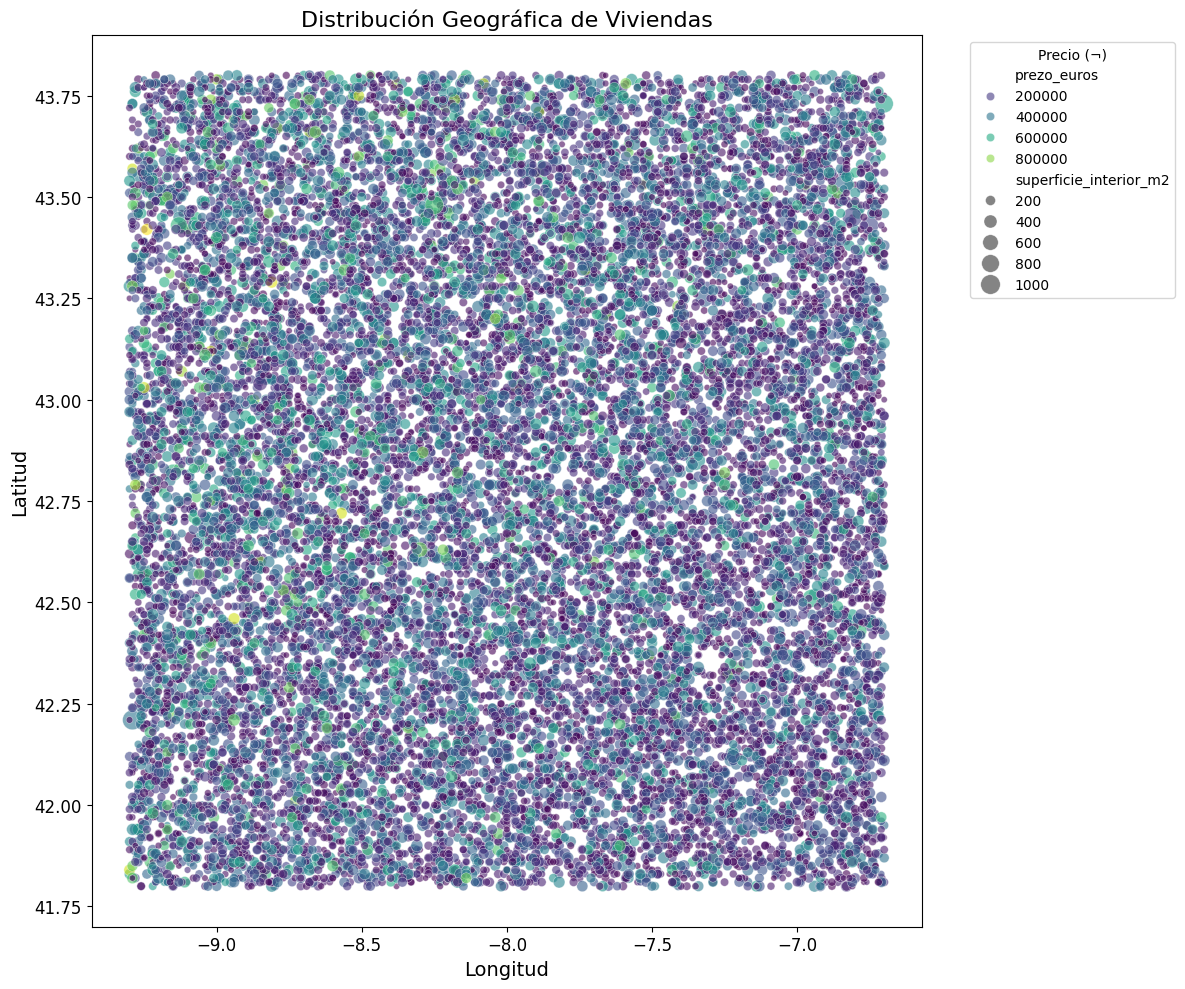

In [28]:
# =============================================================================
# 8. ANÁLISIS GEOESPACIAL
# =============================================================================

# Visualizar distribución geográfica de las viviendas
plt.figure(figsize=(12, 10))
sns.scatterplot(x='lonxitude', y='latitude', hue='prezo_euros', 
                size='superficie_interior_m2', data=train_data,
                palette='viridis', sizes=(20, 200), alpha=0.6)
plt.title('Distribución Geográfica de Viviendas', fontsize=16)
plt.xlabel('Longitud', fontsize=14)
plt.ylabel('Latitud', fontsize=14)
plt.legend(title='Precio (¬)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.savefig('distribucion_geografica.png')
plt.show()


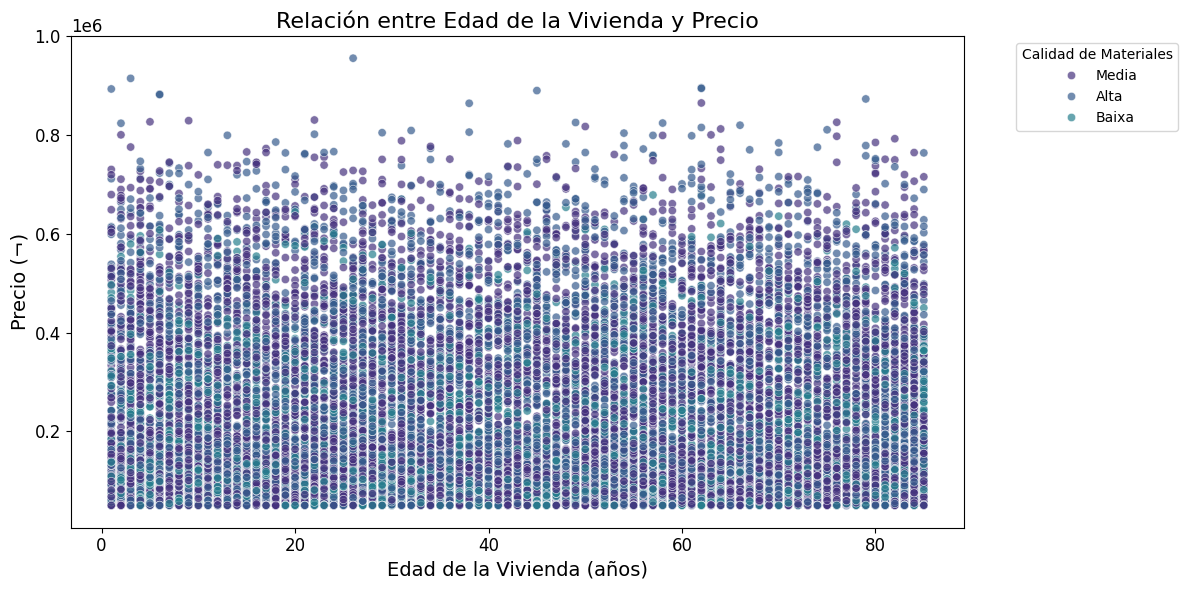

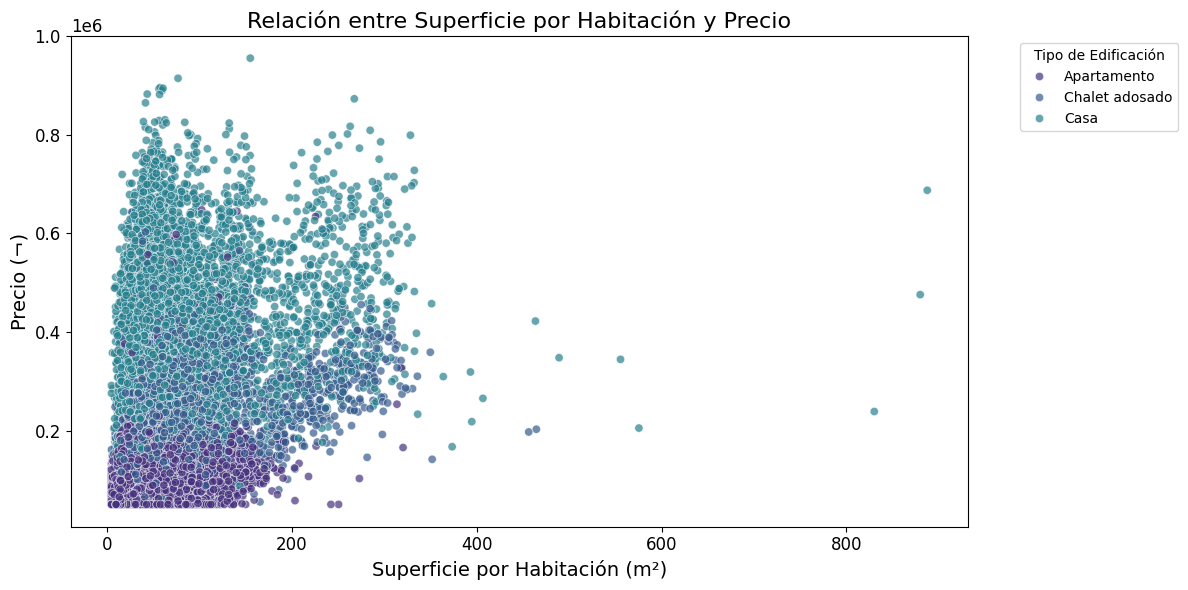

In [29]:
# =============================================================================
# 10. CREACIÓN DE CARACTERÍSTICAS ADICIONALES
# =============================================================================

# Añadir edad de la vivienda (año actual - año construcción)
current_year = 2025  # Año actual del problema
train_data['edad_vivienda'] = current_year - train_data['ano_construccion']

# Ratio superficie por habitación
train_data['superficie_por_habitacion'] = train_data['superficie_interior_m2'] / train_data['numero_habitacions']

# Relación entre edad de la vivienda y precio
plt.figure(figsize=(12, 6))
sns.scatterplot(x='edad_vivienda', y='prezo_euros', 
                hue='calidade_materiais', data=train_data, alpha=0.7)
plt.title('Relación entre Edad de la Vivienda y Precio', fontsize=16)
plt.xlabel('Edad de la Vivienda (años)', fontsize=14)
plt.ylabel('Precio (¬)', fontsize=14)
plt.legend(title='Calidad de Materiales', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.savefig('edad_vs_precio.png')
plt.show()

# Relación entre superficie por habitación y precio
plt.figure(figsize=(12, 6))
sns.scatterplot(x='superficie_por_habitacion', y='prezo_euros', 
                hue='tipo_edificacion', data=train_data, alpha=0.7)
plt.title('Relación entre Superficie por Habitación y Precio', fontsize=16)
plt.xlabel('Superficie por Habitación (m²)', fontsize=14)
plt.ylabel('Precio (¬)', fontsize=14)
plt.legend(title='Tipo de Edificación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.savefig('superficie_por_habitacion_vs_precio.png')
plt.show()



Número de posibles outliers en precio: 238
Porcentaje de outliers: 1.19%


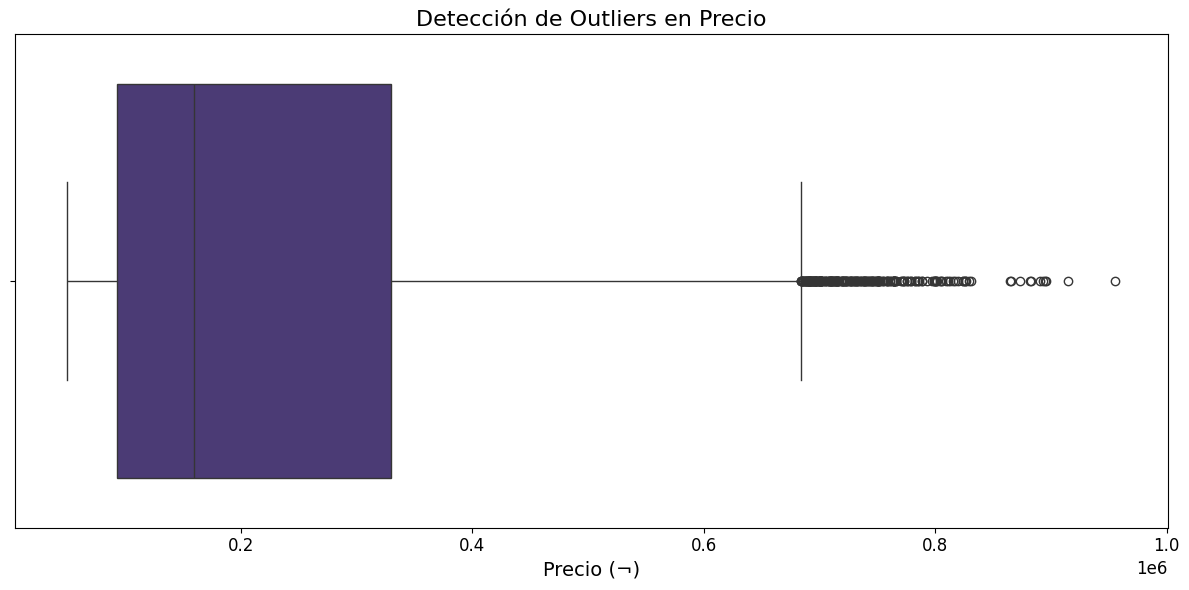

In [30]:
# =============================================================================
# 11. ANÁLISIS DE VALORES ATÍPICOS (OUTLIERS)
# =============================================================================

# Detección de outliers en la variable objetivo
Q1 = train_data['prezo_euros'].quantile(0.25)
Q3 = train_data['prezo_euros'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_data[(train_data['prezo_euros'] < lower_bound) | 
                      (train_data['prezo_euros'] > upper_bound)]

print(f"\nNúmero de posibles outliers en precio: {len(outliers)}")
print(f"Porcentaje de outliers: {len(outliers) / len(train_data) * 100:.2f}%")

# Visualización de outliers en el precio
plt.figure(figsize=(12, 6))
sns.boxplot(x=train_data['prezo_euros'])
plt.title('Detección de Outliers en Precio', fontsize=16)
plt.xlabel('Precio (¬)', fontsize=14)
plt.tight_layout()
#plt.savefig('precio_outliers.png')
plt.show()

In [31]:
# =============================================================================
# 12. CONCLUSIONES Y RESUMEN
# =============================================================================

print("\n=== RESUMEN DEL ANÁLISIS EXPLORATORIO DE DATOS ===")
print(f"1. Tamaño del conjunto de entrenamiento: {train_data.shape[0]} filas, {train_data.shape[1]} columnas")
print(f"2. Valores faltantes: {missing_df[missing_df['Missing Values'] > 0].shape[0]} columnas con valores faltantes")
print(f"3. Rango de precios: {train_data['prezo_euros'].min():.2f}¬ - {train_data['prezo_euros'].max():.2f}¬")
print(f"4. Precio medio: {train_data['prezo_euros'].mean():.2f}¬")
print(f"5. Variables con mayor correlación con el precio:")
for feature, corr in precio_correlations[:5].items():
    if feature != 'prezo_euros':
        print(f"   - {feature}: {corr:.4f}")

# Posibles pasos a seguir basados en el análisis
print("\nPasos a seguir basados en el análisis exploratorio:")
print("1. Imputar valores faltantes para superficie_interior_m2, superficie_exterior_m2 y distancia_centro_km")
print("2. Codificar variables categóricas (tipo_edificacion, calidade_materiais, etc.)")
print("3. Crear características adicionales (ratios, interacciones, features geoespaciales)")
print("4. Considerar transformación logarítmica de la variable objetivo para normalizar su distribución")
print("5. Evaluar el impacto de outliers en el modelado")


=== RESUMEN DEL ANÁLISIS EXPLORATORIO DE DATOS ===
1. Tamaño del conjunto de entrenamiento: 20000 filas, 22 columnas
2. Valores faltantes: 5 columnas con valores faltantes
3. Rango de precios: 50000.00¬ - 955855.00¬
4. Precio medio: 223402.81¬
5. Variables con mayor correlación con el precio:
   - superficie_exterior_m2: 0.8295
   - superficie_interior_m2: 0.7058
   - numero_arboles_xardin: 0.5597
   - distancia_centro_km: 0.4938

Pasos a seguir basados en el análisis exploratorio:
1. Imputar valores faltantes para superficie_interior_m2, superficie_exterior_m2 y distancia_centro_km
2. Codificar variables categóricas (tipo_edificacion, calidade_materiais, etc.)
3. Crear características adicionales (ratios, interacciones, features geoespaciales)
4. Considerar transformación logarítmica de la variable objetivo para normalizar su distribución
5. Evaluar el impacto de outliers en el modelado


# PREPROCESADO

In [32]:
# =============================================================================
# 1. CARGA DE DATOS
# =============================================================================

print("Procesando datos desde cero...")
    
# Cargar los conjuntos de datos originales
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f"Dimensiones del conjunto de entrenamiento: {train_data.shape}")
print(f"Dimensiones del conjunto de prueba: {test_data.shape}")

Procesando datos desde cero...
Dimensiones del conjunto de entrenamiento: (20000, 20)
Dimensiones del conjunto de prueba: (10000, 20)


In [33]:
# =============================================================================
# 2. FUNCIÓN AUXILIAR PARA PREPROCESAMIENTO
# =============================================================================

def preprocess_data(df, is_train=True):

    # Crear una copia para no modificar el original
    data = df.copy()
    
    # =============================================================================
    # 2.1 LIMPIEZA DE DATOS
    # =============================================================================
    
    print("Iniciando limpieza de datos...")
    
    # Eliminar duplicados en el conjunto de entrenamiento
    if is_train:
        duplicates = data.duplicated()
        if duplicates.sum() > 0:
            print(f"Eliminando {duplicates.sum()} filas duplicadas...")
            data = data.drop_duplicates().reset_index(drop=True)
        
        """
        # PEQUEÑA PRUEBA: Filtrar registros con precio de 50000 euros
        price_50k_count = (data['prezo_euros'] == 50000).sum()
        if price_50k_count > 0:
            print(f"Eliminando {price_50k_count} registros con precio exacto de 50000 euros...")
            data = data[data['prezo_euros'] != 50000].reset_index(drop=True)
            print(f"Registros restantes después del filtrado: {len(data)}")
        """

    
    # =============================================================================
    # 2.2 MANEJO DE VALORES FALTANTES
    # =============================================================================
    
    print("Manejando valores faltantes...")
    
    # Chequear valores faltantes antes del preprocesado
    missing_before = data.isnull().sum()
    print("Valores faltantes antes del preprocesado:")
    print(missing_before[missing_before > 0])
    
    # Imputar valores faltantes usando KNN para variables numéricas principales
    numeric_features = [
        'superficie_interior_m2', 
        'superficie_exterior_m2', 
        'distancia_centro_km', 
        'distancia_escola_km', 
        'indice_criminalidade'
    ]
    
    # Seleccionar columnas auxiliares para KNN (que tengan pocos o ningún NA)
    aux_features = [
        'numero_habitacions', 
        'numero_banos', 
        'ano_construccion',
        'lonxitude', 
        'latitude', 
        'temperatura_media_mes_construccion',
        'numero_arboles_xardin'
    ]
    
    # Combinar características para imputer
    imputer_features = numeric_features + aux_features
    
    # Crear una copia temporal para la imputación
    imputer_data = data[imputer_features].copy()
    
    # Inicializar KNN Imputer
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    
    # Aplicar imputación
    imputed_values = imputer.fit_transform(imputer_data)
    
    # Reemplazar valores en el DataFrame original solo para las columnas con NAs
    for i, col in enumerate(numeric_features):
        # Solo imputar si hay valores faltantes en la columna
        if data[col].isnull().sum() > 0:
            data[col] = imputed_values[:, i]
    
    # =============================================================================
    # 2.3 INGENIERÍA DE CARACTERÍSTICAS
    # =============================================================================
    
    print("Creando nuevas características...")
    
    # Año actual para cálculos de edad
    current_year = 2025
    
    # Crear características básicas
    data['edad_vivienda'] = current_year - data['ano_construccion']
    data['superficie_por_habitacion'] = data['superficie_interior_m2'] / data['numero_habitacions']
    data['superficie_total'] = data['superficie_interior_m2'] + data['superficie_exterior_m2']
    data['ratio_interior_exterior'] = data['superficie_interior_m2'] / (data['superficie_exterior_m2'] + 1)  # Evitar división por cero
    data['densidad_banos'] = data['numero_banos'] / data['superficie_interior_m2']
    data['densidad_habitaciones'] = data['numero_habitacions'] / data['superficie_interior_m2']
    
    # Características de localización
    # Calculamos la distancia euclidiana desde algunos puntos de referencia en Galicia
    # Centro aproximado de A Coruña
    data['dist_coruna'] = np.sqrt((data['lonxitude'] - (-8.4))**2 + (data['latitude'] - 43.37)**2)
    # Centro aproximado de Vigo
    data['dist_vigo'] = np.sqrt((data['lonxitude'] - (-8.72))**2 + (data['latitude'] - 42.23)**2)
    # Centro aproximado de Santiago
    data['dist_santiago'] = np.sqrt((data['lonxitude'] - (-8.54))**2 + (data['latitude'] - 42.88)**2)
    
    # Características interactivas
    data['calidad_edad'] = data['edad_vivienda'] * data.apply(
        lambda x: {'Alta': 3, 'Media': 2, 'Baixa': 1}[x['calidade_materiais']] 
        if pd.notna(x['calidade_materiais']) else 2, axis=1)
    
    data['banos_por_habitacion'] = data['numero_banos'] / data['numero_habitacions']
    
    # Características climáticas
    # Codificar la orientación según exposición solar (Sur es mejor)
    orientacion_map = {
        'Sur': 4,
        'Este': 3,
        'Oeste': 2,
        'Norte': 1
    }
    data['orientacion_valor'] = data['orientacion'].map(orientacion_map)
    
    # Codificar eficiencia energética
    eficiencia_map = {
        'A': 7,
        'B': 6,
        'C': 5,
        'D': 4,
        'E': 3,
        'F': 2,
        'G': 1
    }
    data['eficiencia_valor'] = data['eficiencia_enerxetica'].map(eficiencia_map)
    
    # Codificar calidad de materiales
    calidad_map = {
        'Alta': 3,
        'Media': 2,
        'Baixa': 1
    }
    data['calidade_valor'] = data['calidade_materiais'].map(calidad_map)
    
    # Codificar acceso a transporte público
    transporte_map = {
        'Bo': 3,
        'Regular': 2,
        'Malo': 1
    }
    data['transporte_valor'] = data['acceso_transporte_publico'].map(transporte_map)
    
    # Características de tipo de vivienda
    # One-hot encoding para tipo de edificación
    tipo_edificacion_dummies = pd.get_dummies(data['tipo_edificacion'], prefix='tipo')
    data = pd.concat([data, tipo_edificacion_dummies], axis=1)
    
    # One-hot encoding para color favorito del propietario
    color_dummies = pd.get_dummies(data['cor_favorita_propietario'], prefix='color')
    data = pd.concat([data, color_dummies], axis=1)
            
    # =============================================================================
    # 2.4 MANEJO DE OUTLIERS (Solo para entrenamiento)
    # =============================================================================
    
    if is_train:
        print("Analizando outliers...")
        
        # Detectar outliers en el precio
        Q1 = data['prezo_euros'].quantile(0.25)
        Q3 = data['prezo_euros'].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data['prezo_euros'] < lower_bound) | (data['prezo_euros'] > upper_bound)]
        
        print(f"Detectados {len(outliers)} outliers en el precio ({len(outliers)/len(data)*100:.2f}%)")
        
        # Decidimos mantener los outliers 
        #data['is_outlier'] = (data['prezo_euros'] < lower_bound) | (data['prezo_euros'] > upper_bound)
        
        # Transformar la variable objetivo para normalización (log transform)
        #data['log_prezo'] = np.log1p(data['prezo_euros'])
            
    # =============================================================================
    # 2.5 NORMALIZACIÓN Y ESCALADO
    # =============================================================================
    
    print("Escalando características numéricas...")
    
    # Lista de características numéricas para escalar
    numeric_features_to_scale = [
        'superficie_interior_m2', 
        'superficie_exterior_m2',
        'distancia_centro_km', 
        'distancia_escola_km',
        'indice_criminalidade',
        'superficie_por_habitacion',
        'superficie_total',
        'ratio_interior_exterior',
        'densidad_banos',
        'densidad_habitaciones',
        'dist_coruna',
        'dist_vigo',
        'dist_santiago',
        'calidad_edad'
    ]
    
    # No escalamos variables como número de habitaciones, baños, etc. que tienen sentido como están
    
    if is_train:
        # Inicializar el scaler
        scaler = StandardScaler()
        # Ajustar el scaler solo en los datos de entrenamiento
        scaler.fit(data[numeric_features_to_scale])
        # Guardar el scaler para uso futuro
        joblib.dump(scaler, 'scaler.pkl')
    else:
        # Cargar el scaler previamente ajustado
        try:
            scaler = joblib.load('scaler.pkl')
        except:
            print("ADVERTENCIA: No se encontró el scaler. Los datos de prueba no se escalarán correctamente.")
            return data
    
    # Aplicar la transformación
    data[numeric_features_to_scale] = scaler.transform(data[numeric_features_to_scale])
    
    # =============================================================================
    # 2.6 LIMPIAR COLUMNAS INNECESARIAS
    # =============================================================================
    
    print("Limpiando columnas innecesarias...")
    
    # Eliminar columnas originales que ya han sido procesadas o no son necesarias
    columns_to_drop = [
        # No eliminar 'id' ya que se necesita para la presentación
        'tipo_edificacion', 
        'calidade_materiais', 
        'cor_favorita_propietario', 
        'acceso_transporte_publico', 
        'orientacion', 
        'eficiencia_enerxetica'
    ]
    
    data = data.drop(columns=columns_to_drop, errors='ignore')
    
    # Verificar valores faltantes después del preprocesado
    missing_after = data.isnull().sum()
    print("Valores faltantes después del preprocesado:")
    print(missing_after[missing_after > 0])
    
    
    return data

In [34]:
# =============================================================================
# 3. APLICAR PREPROCESAMIENTO
# =============================================================================

print("\nPreprocesando conjunto de entrenamiento...")
train_processed = preprocess_data(train_data, is_train=True)

print("\nPreprocesando conjunto de prueba...")
test_processed = preprocess_data(test_data, is_train=False)

# =============================================================================
# 4. GUARDAR DATOS PROCESADOS
# =============================================================================

print("\nGuardando datos procesados...")
train_processed.to_csv('train_processed_presentacion.csv', index=False)
test_processed.to_csv('test_processed_presentacion.csv', index=False)

print("Datos procesados guardados en 'train_processed_presentacion.csv' y 'test_processed_presentacion.csv'")



Preprocesando conjunto de entrenamiento...
Iniciando limpieza de datos...
Manejando valores faltantes...
Valores faltantes antes del preprocesado:
superficie_interior_m2    1007
superficie_exterior_m2    1027
distancia_centro_km       1011
distancia_escola_km       1021
indice_criminalidade       988
dtype: int64
Creando nuevas características...
Analizando outliers...
Detectados 238 outliers en el precio (1.19%)
Escalando características numéricas...
Limpiando columnas innecesarias...
Valores faltantes después del preprocesado:
Series([], dtype: int64)

Preprocesando conjunto de prueba...
Iniciando limpieza de datos...
Manejando valores faltantes...
Valores faltantes antes del preprocesado:
superficie_interior_m2    487
superficie_exterior_m2    465
distancia_centro_km       487
distancia_escola_km       478
indice_criminalidade      512
dtype: int64
Creando nuevas características...
Escalando características numéricas...
Limpiando columnas innecesarias...
Valores faltantes después d

In [35]:
# =============================================================================
# 5. VISUALIZACIÓN DE RESULTADOS DEL PREPROCESAMIENTO
# =============================================================================

print("\nMostrando información de los datos procesados:")
print(f"Dimensiones del conjunto de entrenamiento procesado: {train_data.shape}")
print(f"Dimensiones del conjunto de prueba procesado: {test_data.shape}")

# Mostrar las primeras filas
print("\nPrimeras filas del conjunto de entrenamiento procesado:")
print(train_data.head())

# Mostrar las columnas disponibles
print("\nColumnas disponibles en el conjunto de entrenamiento procesado:")
print(train_data.columns.tolist())
"""

# Verificar nuevas características creadas
new_features = ['superficie_por_habitacion', 'edad_vivienda', 'superficie_total', 
                'ratio_interior_exterior', 'dist_coruna', 'dist_vigo', 'dist_santiago']
print("\nEstadísticas de las nuevas características:")
print(train_data[new_features].describe())

print("\nPreprocesamiento completado exitosamente.")
"""





Mostrando información de los datos procesados:
Dimensiones del conjunto de entrenamiento procesado: (20000, 20)
Dimensiones del conjunto de prueba procesado: (10000, 20)

Primeras filas del conjunto de entrenamiento procesado:
      id  superficie_interior_m2  superficie_exterior_m2  numero_habitacions  numero_banos  ano_construccion  lonxitude  latitude  temperatura_media_mes_construccion tipo_edificacion  \
0  25521                   44.96                    0.00                   1             2              1947      -8.17     43.20                               24.75      Apartamento   
1   4843                   93.55                   87.26                   2             2              1977      -7.23     43.60                               14.06      Apartamento   
2  27734                  273.64                  187.29                   1             1              1996      -8.40     42.25                               12.27   Chalet adosado   
3  22142                  17

'\n\n# Verificar nuevas características creadas\nnew_features = [\'superficie_por_habitacion\', \'edad_vivienda\', \'superficie_total\', \n                \'ratio_interior_exterior\', \'dist_coruna\', \'dist_vigo\', \'dist_santiago\']\nprint("\nEstadísticas de las nuevas características:")\nprint(train_data[new_features].describe())\n\nprint("\nPreprocesamiento completado exitosamente.")\n'

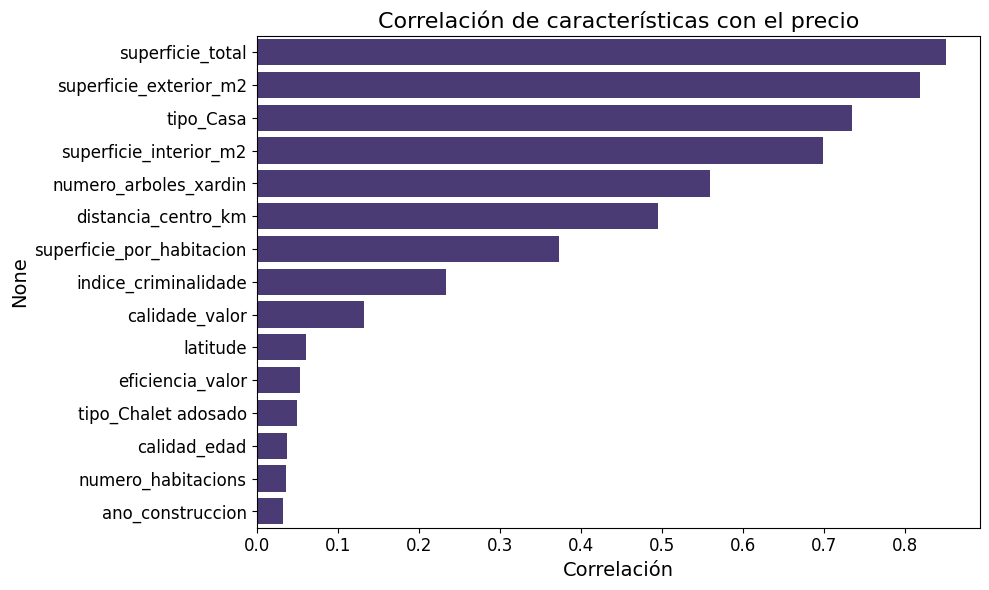

In [36]:
# Calcular la correlación con la variable objetivo
correlaciones = train_processed.corr()['prezo_euros'].sort_values(ascending=False)

# Mostrar solo las correlaciones más altas (por ejemplo, top 15)
top_corr = correlaciones.drop('prezo_euros').head(15)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Correlación de características con el precio')
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()

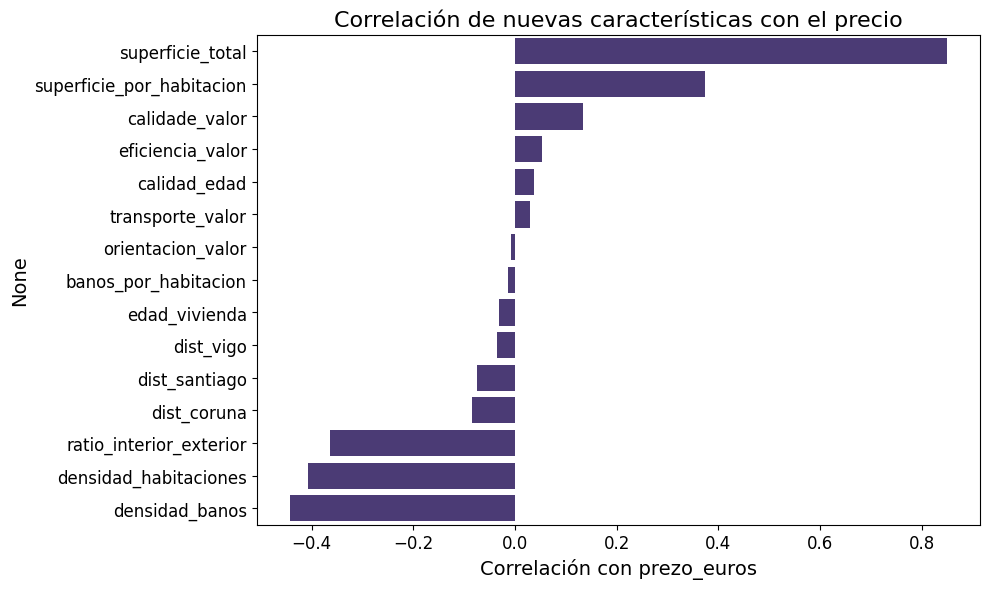

In [37]:
# =============================================================================
# CORRELACIÓN DE NUEVAS CARACTERÍSTICAS CON EL PRECIO (GRÁFICO DE BARRAS)
# =============================================================================

# Lista de nuevas características creadas
nuevas_caracteristicas = [
    'edad_vivienda',
    'superficie_por_habitacion',
    'superficie_total',
    'ratio_interior_exterior',
    'densidad_banos',
    'densidad_habitaciones',
    'dist_coruna',
    'dist_vigo',
    'dist_santiago',
    'calidad_edad',
    'banos_por_habitacion',
    'orientacion_valor',
    'eficiencia_valor',
    'calidade_valor',
    'transporte_valor'
]

# Calcular correlación con el precio
correlaciones = train_processed[nuevas_caracteristicas + ['prezo_euros']].corr()['prezo_euros']
correlaciones = correlaciones.drop('prezo_euros').sort_values(ascending=False)

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(x=correlaciones.values, y=correlaciones.index)
plt.title('Correlación de nuevas características con el precio')
plt.xlabel('Correlación con prezo_euros')
plt.tight_layout()
plt.show()


# MODELOS BASE

## CatBoost

CatBoost es un algoritmo de *gradient boosting* diseñado específicamente para trabajar de manera nativa con variables categóricas, sin necesidad de transformaciones manuales como *one-hot encoding* o *target encoding*. 

Utiliza:

- Árboles de decisión simétricos (*oblivious trees*).
- Codificación de categorías basada en estadísticas ordenadas (*ordered target statistics*), evitando fugas de información.
- *Ordered boosting*, que divide los gradientes en bloques, reduciendo el sobreajuste.

Estas características permiten una alta precisión y estabilidad desde el primer entrenamiento.

### Configuración inicial

Inicializamos `CatBoostRegressor` con:

- `iterations=10000`
- `learning_rate=0.05`
- `depth=3`
- `loss_function='MAE'`
- `eval_metric='MAE'`

Durante el entrenamiento usamos conjuntos de entrenamiento y validación empaquetados en objetos `Pool`, indicando explícitamente las columnas categóricas y activando `use_best_model=True` para detener el entrenamiento al dejar de mejorar el MAE en validación.

Resultados obtenidos en el 10 % reservado para test:

- MAE mínimo: **29 344,46**
- RMSE: **41 309,35**
- R²: **0,9378**

### Búsqueda de hiperparámetros

Posteriormente, realizamos una búsqueda en rejilla (`Grid Search`) centrada en:

- `learning_rate`: [0.1, 0.08, 0.05, 0.03, 0.01]
- `depth`: de 1 a 7
- `iterations`: fijado en 5 000 para acelerar la validación cruzada

Utilizamos `GridSearchCV` con 3 pliegues y propagamos `cat_features` al método `fit`. La búsqueda, paralelizada en todos los núcleos disponibles, nos proporcionó el mejor MAE medio en validación cruzada (3-fold CV).

El modelo resultante se validó nuevamente sobre el 10 % de test reservado, confirmando la mejora. Finalmente, guardamos el modelo optimizado en formato `.cbm` y exportamos los resultados detallados en un archivo `.csv` para análisis futuros.


In [38]:
# Configuración para visualización
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")
os.makedirs('results_initial_hyper', exist_ok=True)

# Función para cargar y preparar los datos
def load_data(file_path):
    df = pd.read_csv(file_path)
    
    # Verificar y gestionar valores faltantes
    print(f"Valores faltantes en el dataset: {df.isnull().sum().sum()}")
    
    # Identificar columnas categóricas automáticamente (si es necesario)
    categorical_features = []
    for col in df.columns:
        if df[col].dtype == 'object' or col in ['tipo_edificacion', 'calidade_materiais', 
                                               'cor_favorita_propietario', 'acceso_transporte_publico',
                                               'orientacion', 'eficiencia_enerxetica']:
            categorical_features.append(col)
    
    print(f"Características categóricas detectadas: {categorical_features}")
    
    # Separamos features y target
    X = df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y = df['prezo_euros']
    
    print(f"Forma del dataset: {df.shape}")
    print(f"Features incluidas: {X.columns.tolist()}")
    
    return X, y, categorical_features

In [39]:
# FASE 1: Entrenamiento base y análisis
def train_initial_model(X, y, cat_features=None, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=random_state
    )
    
    initial_params = {
        'iterations': 10000,
        'learning_rate': 0.05,
        'depth': 3,
        'loss_function': 'MAE',
        'eval_metric': 'MAE',
        'random_seed': random_state,
        'verbose': 200
    }
    
    print("\n=== Entrenando modelo inicial para análisis ===")
    
    # Crear pool de datos para CatBoost
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)
    
    # Entrenar modelo
    model = CatBoostRegressor(**initial_params)
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)
    
    # Evaluar modelo
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Métricas del modelo inicial:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    
    
    
    # Analizar importancia de características
    feature_importance = model.get_feature_importance()
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    """
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 características más importantes', fontsize=15)
    plt.tight_layout()
    plt.savefig('results_initial_hyper/initial_feature_importance.png')
    
    """
    
    
    print("\nAnálisis de características completado - Ver 'results_initial_hyper/initial_feature_importance.png'")
    
    # Devolver todo lo necesario para optimización
    return model, X_train, X_test, y_train, y_test, cat_features, importance_df

In [40]:
# FASE 2: Optimización con Grid Search (solo sobre los parámetros iniciales)
def optimize_with_grid_search(X_train, y_train, X_test, y_test, cat_features=None, random_state=42):
    print("\n=== Optimización con Grid Search ===")
    
    # Grid de parámetros a evaluar (solo los parámetros iniciales)
    param_grid = {
        'iterations': [5000],
        'learning_rate': [0.1,0.08, 0.05, 0.03, 0.01],
        'depth': [1,2,3,4,5,6,7],
    }
    
    # Crear pool para entrenamiento
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    
    # Configurar modelo base para GridSearch
    base_model = CatBoostRegressor(
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=random_state,
        verbose=100
    )
    
    # Configurar GridSearchCV
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,  # Usar validación cruzada con 3 folds
        scoring='neg_mean_absolute_error',
        n_jobs=-1,  # Usar todos los núcleos disponibles
        verbose=1
    )
    
    # Entrenar Grid Search
    start_time = time.time()
    grid_search.fit(X_train, y_train, cat_features=cat_features)
    gs_time = time.time() - start_time
    
    # Mejor valor de MAE encontrado
    print(f"Tiempo de Grid Search: {gs_time:.2f} segundos")
    print(f"Mejor MAE encontrado: {-grid_search.best_score_:.2f}")
    print(f"Mejores parámetros: {grid_search.best_params_}")
    
    # Evaluar mejor modelo en conjunto de prueba
    best_gs_model = grid_search.best_estimator_
    y_pred = best_gs_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"MAE en conjunto de prueba: {mae:.2f}")
    
    # Guardar modelo optimizado en formato CatBoost .cbm
    best_gs_model.save_model('results_initial_hyper/best_model_long.cbm')
    print("\nModelo guardado como 'results_initial_hyper/best_model.cbm'")
    
    # Guardar resultados
    gs_results = pd.DataFrame(grid_search.cv_results_)
    gs_results.to_csv('results_initial_hyper/grid_search_results.csv', index=False)
    
    return best_gs_model, grid_search.best_params_

In [41]:
# Fase de ejecución del script
if __name__ == "__main__":
    # Cargar datos
    X, y, cat_features = load_data('train_processed.csv')
    
    # Entrenar el modelo inicial
    model, X_train, X_test, y_train, y_test, cat_features, importance_df = train_initial_model(X, y, cat_features)
    
    # Guardar modelo optimizado en formato CatBoost .cbm
    model.save_model('results_initial_hyper/best_model_initial.cbm')
    print("\nModelo guardado como 'results_initial_hyper/best_model.cbm'")

    # Evaluar mejor modelo en conjunto de prueba
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"MAE en conjunto de prueba: {mae:.2f}")
    
    # Guardar resultados
    #gs_results = pd.DataFrame(model.cv_results_)
    #gs_results.to_csv('results_initial_hyper/grid_search_results.csv', index=False)
    
    # Optimización de hiperparámetros con GridSearch
    #best_model, best_params = optimize_with_grid_search(X_train, y_train, X_test, y_test, cat_features)


Valores faltantes en el dataset: 0
Características categóricas detectadas: []
Forma del dataset: (20000, 47)
Features incluidas: ['superficie_interior_m2', 'superficie_exterior_m2', 'numero_habitacions', 'numero_banos', 'ano_construccion', 'lonxitude', 'latitude', 'temperatura_media_mes_construccion', 'distancia_centro_km', 'distancia_escola_km', 'indice_criminalidade', 'numero_arboles_xardin', 'edad_vivienda', 'superficie_por_habitacion', 'superficie_total', 'ratio_interior_exterior', 'densidad_banos', 'densidad_habitaciones', 'dist_coruna', 'dist_vigo', 'dist_santiago', 'calidad_edad', 'banos_por_habitacion', 'orientacion_valor', 'eficiencia_valor', 'calidade_valor', 'transporte_valor', 'tipo_Apartamento', 'tipo_Casa', 'tipo_Chalet adosado', 'color_Amarelo', 'color_Azul', 'color_Branco', 'color_Negro', 'color_Verde', 'color_Vermello', 'tipo_Apartamento.1', 'tipo_Casa.1', 'tipo_Chalet adosado.1', 'color_Amarelo.1', 'color_Azul.1', 'color_Branco.1', 'color_Negro.1', 'color_Verde.1', 'c

## XGBoost

XGBoost (eXtreme Gradient Boosting) es un algoritmo de ensamble basado en *gradient boosting* que construye de forma aditiva un conjunto de árboles de decisión débiles para minimizar una función de pérdida diferenciable. 

A diferencia de implementaciones más sencillas de boosting, XGBoost incorpora de manera nativa:

- Regularización L1 y L2 sobre los pesos de los árboles.
- Optimización por segundo orden (utilizando las derivadas primeras y segundas de la función de pérdida).
- Manejo eficiente de datos dispersos o faltantes.

Gracias a su implementación interna, garantiza un entrenamiento extremadamente rápido y escalable, incluso en conjuntos de datos de gran tamaño. Además, ofrece funcionalidades avanzadas como:

- `column subsampling`
- `row subsampling`
- `shrinkage`
- `early stopping`

Estas técnicas ayudan a evitar el sobreajuste y mejorar la generalización.

### Ajuste de hiperparámetros

Para optimizar el rendimiento de `XGBRegressor`, realizamos una búsqueda exhaustiva de hiperparámetros mediante `GridSearchCV` con validación cruzada de 5 pliegues, utilizando el error absoluto medio (MAE) como métrica de selección. Se exploraron:

- `n_estimators`: número de árboles.
- `learning_rate`: controla el aporte de cada árbol.
- `max_depth` y `min_child_weight`: regulan la profundidad y tamaño mínimo de las hojas.
- `subsample` y `colsample_bytree`: muestrean filas y columnas, reduciendo la correlación entre árboles.
- `reg_alpha` y `reg_lambda`: aplican regularización L1 y L2.

Esta estrategia permitió identificar la combinación que minimiza el MAE medio en entrenamiento, equilibrando sesgo y varianza. Con los mejores parámetros, entrenamos el modelo sobre el 90 % de los datos y validamos sobre el 10 % restante, obteniendo métricas robustas y un ranking claro de importancia de características.


In [42]:
# Create directory for results
os.makedirs('models', exist_ok=True)
os.makedirs('results_xgboost', exist_ok=True)

# Set visualization parameters
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")

In [43]:
# Function to load and prepare data
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Valores faltantes en el dataset: {df.isnull().sum().sum()}")
    
    # Identify categorical features
    categorical_features = []
    for col in df.columns:
        if df[col].dtype == 'object' or col in ['tipo_edificacion', 'calidade_materiais', 
                                               'cor_favorita_propietario', 'acceso_transporte_publico',
                                               'orientacion', 'eficiencia_enerxetica'] or 'tipo_' in col or 'color_' in col:
            categorical_features.append(col)
    
    print(f"Características categóricas detectadas: {categorical_features}")
    
    # Separate features and target
    X = df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y = df['prezo_euros']
    
    print(f"Forma del dataset: {df.shape}")
    print(f"Features incluidas: {X.columns.tolist()}")
    
    return X, y, categorical_features

In [44]:
# Function to train XGBoost model
def train_xgboost_model(X, y, random_state=42):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=random_state
    )
    
    print("\n=== Entrenando modelo XGBoost ===")
    
    # Initial hyperparameters
    param_grid = {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1, 1.5, 2],
        'objective': ['reg:squarederror']
    }
    
    # Simplified version for faster execution
    simple_param_grid = {
        'n_estimators': [200, 500],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'objective': ['reg:squarederror']
    }
    
    # Create model
    model = XGBRegressor(random_state=random_state)
    
    # Grid search with cross-validation
    print("Realizando búsqueda de hiperparámetros con GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Best parameters
    print(f"Mejores hiperparámetros: {grid_search.best_params_}")
    
    # Train final model
    best_model = XGBRegressor(**grid_search.best_params_, random_state=random_state)
    best_model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Métricas del modelo XGBoost:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    
    # Feature importance
    feature_importance = best_model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 características más importantes (XGBoost)', fontsize=15)
    plt.tight_layout()
    plt.savefig('results_xgboost/xgboost_feature_importance.png')
    
    print("\nAnálisis de características completado - Ver 'results_xgboost/xgboost_feature_importance.png'")
    
    return best_model

In [45]:
# Main execution
if __name__ == "__main__":
    start_time = time.time()
    
    # Load data
    X, y, cat_features = load_data('train_processed.csv')
    
    # Train XGBoost model
    model = train_xgboost_model(X, y)
    
    # Save model
    model.save_model('models_stacking/stacking_xgboost_model.json')
    print("\nModelo guardado como 'models/xgboost_model.json'")
    
    end_time = time.time()
    print(f"Tiempo total de ejecución: {end_time - start_time:.2f} segundos")

Valores faltantes en el dataset: 0
Características categóricas detectadas: ['tipo_Apartamento', 'tipo_Casa', 'tipo_Chalet adosado', 'color_Amarelo', 'color_Azul', 'color_Branco', 'color_Negro', 'color_Verde', 'color_Vermello', 'tipo_Apartamento.1', 'tipo_Casa.1', 'tipo_Chalet adosado.1', 'color_Amarelo.1', 'color_Azul.1', 'color_Branco.1', 'color_Negro.1', 'color_Verde.1', 'color_Vermello.1']
Forma del dataset: (20000, 47)
Features incluidas: ['superficie_interior_m2', 'superficie_exterior_m2', 'numero_habitacions', 'numero_banos', 'ano_construccion', 'lonxitude', 'latitude', 'temperatura_media_mes_construccion', 'distancia_centro_km', 'distancia_escola_km', 'indice_criminalidade', 'numero_arboles_xardin', 'edad_vivienda', 'superficie_por_habitacion', 'superficie_total', 'ratio_interior_exterior', 'densidad_banos', 'densidad_habitaciones', 'dist_coruna', 'dist_vigo', 'dist_santiago', 'calidad_edad', 'banos_por_habitacion', 'orientacion_valor', 'eficiencia_valor', 'calidade_valor', 'tra

KeyboardInterrupt: 

## LightGBM

LightGBM (Light Gradient Boosting Machine) implementa un enfoque de *gradient boosting* optimizado para velocidad y escalabilidad, especialmente en grandes volúmenes de datos. A diferencia de otros frameworks, LightGBM utiliza la construcción de árboles *leaf-wise* (por hoja) en lugar de *depth-wise*, lo que permite reducir la pérdida de manera más agresiva en cada iteración al expandir la rama con mayor ganancia.

Para gestionar la complejidad y evitar el sobreajuste, incorpora:

- `feature_fraction`: muestreo aleatorio de características (columnas).
- `bagging_fraction` y `bagging_freq`: muestreo aleatorio de instancias (filas).
- Histogramas internos: agrupan valores continuos en *buckets*, acelerando el cálculo de ganancias y reduciendo el uso de memoria.

### Proceso de entrenamiento

- Se cargó el conjunto de datos procesado, con 20 000 filas y 47 columnas sin valores faltantes.
- LightGBM detectó automáticamente 18 variables como categóricas.
- Se utilizó `LGBMRegressor`, dividiendo el conjunto de datos en 90 % para entrenamiento y 10 % para validación.

### Búsqueda de hiperparámetros

Se aplicó `GridSearchCV` con validación cruzada de 5 pliegues, explorando una malla de 16 combinaciones sobre los siguientes parámetros:

- `num_leaves`
- `learning_rate`
- `n_estimators`
- `min_child_samples`
- `subsample`
- `colsample_bytree`

Esto dio lugar a 80 ajustes distintos.

### Entrenamiento final

El modelo se entrenó con el API de LightGBM usando *early stopping* de 50 rondas sin mejora en MAE sobre el conjunto de validación, deteniéndose automáticamente para evitar sobreajuste.

La evaluación sobre el 10 % de test arrojó métricas comparables a las de otros algoritmos probados. El modelo final se guardó en disco como `stacking_lightgbm_model.txt` para su uso en el ensamblado de modelos.


In [46]:
# Create directory for results
os.makedirs('models', exist_ok=True)
os.makedirs('results_lightgbm', exist_ok=True)

# Set visualization parameters
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")

In [47]:
# Function to load and prepare data
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Valores faltantes en el dataset: {df.isnull().sum().sum()}")
    
    # Identify categorical features
    categorical_features = []
    for col in df.columns:
        if df[col].dtype == 'object' or col in ['tipo_edificacion', 'calidade_materiais', 
                                              'cor_favorita_propietario', 'acceso_transporte_publico',
                                              'orientacion', 'eficiencia_enerxetica'] or 'tipo_' in col or 'color_' in col:
            categorical_features.append(col)
    
    print(f"Características categóricas detectadas: {categorical_features}")
    
    # Separate features and target
    X = df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y = df['prezo_euros']
    
    print(f"Forma del dataset: {df.shape}")
    print(f"Features incluidas: {X.columns.tolist()}")
    
    return X, y, categorical_features

In [48]:
# Function to train LightGBM model
def train_lightgbm_model(X, y, categorical_features=None, random_state=42):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=random_state
    )
    
    print("\n=== Entrenando modelo LightGBM ===")
    
    # Prepare data
    categorical_feature_indices = []
    if categorical_features:
        categorical_feature_indices = [list(X.columns).index(col) for col in categorical_features if col in X.columns]
    
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_feature_indices)
    valid_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_feature_indices, reference=train_data)
    
    # Parameters
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': random_state
    }
    
    # Grid search for hyperparameters
    param_grid = {
        'num_leaves': [15, 31, 63],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 500],
        'min_child_samples': [5, 10, 20],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    # Simplified grid for faster execution
    simple_param_grid = {
        'num_leaves': [31, 63],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [200, 500],
        'min_child_samples': [10,20],
        'subsample': [0.8],
        'colsample_bytree': [1.0]
    }
    
    lgb_model = lgb.LGBMRegressor(objective='regression', random_state=random_state, verbose=-1)
    
    print("Realizando búsqueda de hiperparámetros con GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=lgb_model,
        param_grid=simple_param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Convert categorical features list to indices for sklearn API
    if categorical_features:
        cat_indices = [i for i, col in enumerate(X.columns) if col in categorical_features]
    else:
        cat_indices = 'auto'
    
    grid_search.fit(X_train, y_train, eval_metric='mae', categorical_feature=cat_indices)
    
    print(f"Mejores hiperparámetros: {grid_search.best_params_}")
    
    # Train final model with best parameters
    final_params = {**params, **grid_search.best_params_}
    best_model = lgb.train(
        final_params,
        train_data,
        num_boost_round=final_params.get('n_estimators', 500),
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
    )
    
    # Evaluate model
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Métricas del modelo LightGBM:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    
    """
    
    # Feature importance
    feature_importance = best_model.feature_importance()
    feature_names = best_model.feature_name()
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 características más importantes (LightGBM)', fontsize=15)
    plt.tight_layout()
    plt.savefig('results_lightgbm/lightgbm_feature_importance.png')
    """
    
    
    print("\nAnálisis de características completado - Ver 'results_lightgbm/lightgbm_feature_importance.png'")
    
    return best_model

In [49]:
# Main execution
if __name__ == "__main__":
    start_time = time.time()
    
    # Load data
    X, y, cat_features = load_data('train_processed.csv')
    
    # Train LightGBM model
    model = train_lightgbm_model(X, y, cat_features)
    
    # Save model
    model.save_model('models_stacking/stacking_lightgbm_model.txt')
    print("\nModelo guardado como 'models/lightgbm_model.txt'")
    
    end_time = time.time()
    print(f"Tiempo total de ejecución: {end_time - start_time:.2f} segundos")

Valores faltantes en el dataset: 0
Características categóricas detectadas: ['tipo_Apartamento', 'tipo_Casa', 'tipo_Chalet adosado', 'color_Amarelo', 'color_Azul', 'color_Branco', 'color_Negro', 'color_Verde', 'color_Vermello', 'tipo_Apartamento.1', 'tipo_Casa.1', 'tipo_Chalet adosado.1', 'color_Amarelo.1', 'color_Azul.1', 'color_Branco.1', 'color_Negro.1', 'color_Verde.1', 'color_Vermello.1']
Forma del dataset: (20000, 47)
Features incluidas: ['superficie_interior_m2', 'superficie_exterior_m2', 'numero_habitacions', 'numero_banos', 'ano_construccion', 'lonxitude', 'latitude', 'temperatura_media_mes_construccion', 'distancia_centro_km', 'distancia_escola_km', 'indice_criminalidade', 'numero_arboles_xardin', 'edad_vivienda', 'superficie_por_habitacion', 'superficie_total', 'ratio_interior_exterior', 'densidad_banos', 'densidad_habitaciones', 'dist_coruna', 'dist_vigo', 'dist_santiago', 'calidad_edad', 'banos_por_habitacion', 'orientacion_valor', 'eficiencia_valor', 'calidade_valor', 'tra

KeyboardInterrupt: 

## Red Neuronal MLP (Scikit-learn)

Se implementó un modelo de red neuronal de tipo perceptrón multicapa (MLP) utilizando `scikit-learn`, con el objetivo de capturar relaciones no lineales entre variables estructurales, geográficas y sociales del dataset de viviendas en Galicia.

### Preparación de datos

- Se cargó el dataset procesado `train_processed.csv`, con 20 000 registros.
- Se detectaron automáticamente 18 variables categóricas relevantes.
- Las variables objetivo y predictoras se separaron, eliminando `id` y `prezo_euros` del conjunto de entrada.

### Escalado y división

Antes del entrenamiento:

- Se aplicó `StandardScaler` para normalizar las variables numéricas.
- Los datos se dividieron en 90 % para entrenamiento y 10 % para validación.
- El escalador se guardó en disco (`models/mlp_scaler.pkl`) para uso futuro en inferencia.

### Búsqueda de hiperparámetros

Se exploraron combinaciones de hiperparámetros con `GridSearchCV` (5 pliegues, métrica MAE negativa), utilizando paralelización completa con `n_jobs=-1`. La rejilla de parámetros incluyó:

- `hidden_layer_sizes`: [(50,), (100,), (100, 50), (250, 100)]
- `activation`: ['relu']
- `solver`: ['adam']
- `alpha`: [0.001, 0.01]
- `learning_rate`: ['constant', 'adaptive']
- `max_iter`: [500, 1000]

La mejor configuración identificada se usó para entrenar el modelo final `MLPRegressor`, logrando ajustar correctamente el entrenamiento sin caer en sobreajuste.

### Evaluación del modelo

Sobre el conjunto de test (10 % reservado), el modelo arrojó las siguientes métricas:

- **MAE**: 31 231  
- **RMSE**: 43 258  
- **R²**: 0,9318  

Estas métricas se consideran competitivas en comparación con los demás modelos del proyecto.

### Visualización de resultados

Se generaron y guardaron dos gráficos clave:

- Curva de pérdida durante el entrenamiento (`results_mlp/mlp_loss_curve.png`), donde la pérdida descendió consistentemente.
- Gráfico de errores vs. precio real (`results_mlp/mlp_error_analysis.png`), mostrando una dispersión homogénea sin sesgos sistemáticos.

### Almacenamiento

El modelo final, junto con su escalador, se encapsuló en un objeto y se guardó como `models_stacking/stacking_mlp_model.pkl`, permitiendo su integración posterior en el ensamblado de modelos.

La ejecución total del script permitió dejar trazabilidad completa del entrenamiento y resultados del MLP, abriendo la posibilidad de reutilizar o ajustar la arquitectura con facilidad.


In [50]:
# Create directory for results
os.makedirs('models', exist_ok=True)
os.makedirs('results_mlp', exist_ok=True)

# Set visualization parameters
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")

In [51]:
# Function to load and prepare data
def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Valores faltantes en el dataset: {df.isnull().sum().sum()}")
    
    # Identify categorical features
    categorical_features = []
    for col in df.columns:
        if df[col].dtype == 'object' or col in ['tipo_edificacion', 'calidade_materiais', 
                                               'cor_favorita_propietario', 'acceso_transporte_publico',
                                               'orientacion', 'eficiencia_enerxetica'] or 'tipo_' in col or 'color_' in col:
            categorical_features.append(col)
    
    print(f"Características categóricas detectadas: {categorical_features}")
    
    # Separate features and target
    X = df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y = df['prezo_euros']
    
    print(f"Forma del dataset: {df.shape}")
    print(f"Features incluidas: {X.columns.tolist()}")
    
    return X, y, categorical_features

In [52]:
# Function to train MLP model
def train_mlp_model(X, y, random_state=42):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=random_state
    )
    
    print("\n=== Entrenando modelo MLP (Red Neuronal) ===")
    
    # Standardize data for neural network
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Save scaler for later use
    joblib.dump(scaler, 'models/mlp_scaler.pkl')
    print("Scaler guardado como 'models/mlp_scaler.pkl'")
    
    # Initial hyperparameters
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (250,100)],
        'activation': ['relu'],
        'solver': ['adam'],
        'alpha': [ 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [500, 1000]
    }
    
    # Simplified grid for faster execution
    simple_param_grid = {
        'hidden_layer_sizes': [(100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001],
        'max_iter': [500]
    }
    
    # Create model
    model = MLPRegressor(random_state=random_state)
    
    # Grid search with cross-validation
    print("Realizando búsqueda de hiperparámetros con GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train_scaled, y_train)
    
    # Best parameters
    print(f"Mejores hiperparámetros: {grid_search.best_params_}")
    
    # Train final model
    best_model = MLPRegressor(**grid_search.best_params_, random_state=random_state)
    best_model.fit(X_train_scaled, y_train)
    
    # Evaluate model
    y_pred = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Métricas del modelo MLP:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2: {r2:.4f}")
    
    # Create a combined model object with the scaler and MLP model
    mlp_model = {
        'scaler': scaler,
        'model': best_model
    }
    
    # Plot loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(best_model.loss_curve_)
    plt.title('Curva de pérdida durante el entrenamiento', fontsize=15)
    plt.xlabel('Iteraciones')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('results_mlp/mlp_loss_curve.png')
    print("\nCurva de pérdida guardada - Ver 'results_mlp/mlp_loss_curve.png'")
    
    # Analyze prediction errors
    errors = y_test - y_pred
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, errors)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Errores de predicción vs Valores reales', fontsize=15)
    plt.xlabel('Precio real')
    plt.ylabel('Error')
    plt.grid(True)
    plt.savefig('results_mlp/mlp_error_analysis.png')
    print("Análisis de errores guardado - Ver 'results_mlp/mlp_error_analysis.png'")
    
    return mlp_model

In [53]:
# Main execution
if __name__ == "__main__":
    start_time = time.time()
    
    # Load data
    X, y, cat_features = load_data('train_processed.csv')
    
    # Train MLP model
    model = train_mlp_model(X, y)
    
    # Save model
    joblib.dump(model, 'models_stacking/stacking_mlp_model.pkl')
    print("\nModelo guardado como 'models/mlp_model.pkl'")
    
    end_time = time.time()
    print(f"Tiempo total de ejecución: {end_time - start_time:.2f} segundos")

Valores faltantes en el dataset: 0
Características categóricas detectadas: ['tipo_Apartamento', 'tipo_Casa', 'tipo_Chalet adosado', 'color_Amarelo', 'color_Azul', 'color_Branco', 'color_Negro', 'color_Verde', 'color_Vermello', 'tipo_Apartamento.1', 'tipo_Casa.1', 'tipo_Chalet adosado.1', 'color_Amarelo.1', 'color_Azul.1', 'color_Branco.1', 'color_Negro.1', 'color_Verde.1', 'color_Vermello.1']
Forma del dataset: (20000, 47)
Features incluidas: ['superficie_interior_m2', 'superficie_exterior_m2', 'numero_habitacions', 'numero_banos', 'ano_construccion', 'lonxitude', 'latitude', 'temperatura_media_mes_construccion', 'distancia_centro_km', 'distancia_escola_km', 'indice_criminalidade', 'numero_arboles_xardin', 'edad_vivienda', 'superficie_por_habitacion', 'superficie_total', 'ratio_interior_exterior', 'densidad_banos', 'densidad_habitaciones', 'dist_coruna', 'dist_vigo', 'dist_santiago', 'calidad_edad', 'banos_por_habitacion', 'orientacion_valor', 'eficiencia_valor', 'calidade_valor', 'tra

KeyboardInterrupt: 

## Red Neuronal MLP (PyTorch)

La red neuronal de perceptrón multicapa (MLP) diseñada en PyTorch emplea una arquitectura profunda y regularizada para capturar relaciones no lineales complejas.

### Preprocesamiento

- Escalado de variables numéricas con `StandardScaler` (parámetros guardados con `joblib`).
- Conversión de datos a tensores.
- Carga en `DataLoader` con mini-batches de 64 muestras para mejorar la estabilidad del gradiente.

### Arquitectura del modelo

- Capas densas de: **256 → 128 → 64 → 32** neuronas antes de la capa de salida.
- Normalización con `BatchNorm1d`.
- Activación no lineal `SiLU` (Swish).
- `Dropout` del 25 % en la primera capa para reducir el co-adaptamiento.

### Entrenamiento

- Optimización con `Adam` (learning rate = 0.001).
- Función de pérdida: `L1Loss` (MAE).
- 300 épocas de entrenamiento.

La pérdida descendió desde ≈ 223 000 a ≈ 35 000 en las primeras 10 épocas, y alcanzó un plateau de ≈ 28 000–30 000 tras 200 épocas, indicando una convergencia sólida.

### Resultados en test (10 % reservado)

- **MAE**: 31 532,91  
- **RMSE**: 44 749,41  
- **R²**: 0,9270

El gráfico de errores versus precio real mostró una dispersión homogénea de los residuos, sin sesgos evidentes.

### Guardado

Se almacenó:

- El estado del modelo en `.pt`
- La curva de entrenamiento
- El gráfico de errores

Esto proporciona trazabilidad completa del proceso y permite ajustes futuros en la arquitectura (capas, neuronas, `dropout`, etc.).


In [54]:
# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results_mlp', exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

def load_data(file_path):
    df = pd.read_csv(file_path)
    print(f"Valores faltantes: {df.isnull().sum().sum()}")
    categorical_features = [col for col in df.columns if 'tipo_' in col or 'color_' in col]
    X = df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y = df['prezo_euros']
    return X, y, categorical_features

Usando dispositivo: cpu


/home/kike/Documentos/4 GREI/AA/AA-P4/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [55]:
class MLPRegressorTorch(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressorTorch, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.25),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.SiLU(),

            nn.Linear(64, 32),
            nn.SiLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [56]:
def train_torch_model(X, y, epochs=300, batch_size=64, lr=0.001):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    joblib.dump(scaler, 'models/mlp_scaler.pkl')

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MLPRegressorTorch(X.shape[1]).to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f"Época {epoch}: Loss {avg_loss:.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor.to(device)).cpu().numpy().flatten()
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    print(f"\n--- Métricas ---\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR2: {r2:.4f}")

    # Save model
    torch.save(model.state_dict(), 'models_stacking/mlp_torch_model.pt')
    print("Modelo guardado como 'models/mlp_torch_model.pt'")

    # Loss curve
    plt.figure()
    plt.plot(losses)
    plt.title("Curva de pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig("results_mlp/mlp_loss_curve.png")

    # Error analysis
    errors = y_test.values - predictions
    plt.figure()
    plt.scatter(y_test.values, errors)
    plt.axhline(0, color='r')
    plt.title("Errores de predicción vs Precio real")
    plt.xlabel("Precio real")
    plt.ylabel("Error")
    plt.grid(True)
    plt.savefig("results_mlp/mlp_error_analysis.png")

    return model

In [57]:
if __name__ == "__main__":
    start = time.time()
    X, y, _ = load_data('train_processed.csv')
    model = train_torch_model(X, y)
    print(f"\nTiempo total: {time.time() - start:.2f} s")

Valores faltantes: 0
Época 0: Loss 223374.5011
Época 10: Loss 64340.8421


KeyboardInterrupt: 

## Modelo de Ensemble: Stacking

Con el objetivo de mejorar la capacidad predictiva del sistema y reducir la varianza inherente a cada modelo individual, se implementó una estrategia de ensamblado basada en **stacking**. Esta técnica consiste en combinar las predicciones de varios modelos base entrenados de forma independiente y alimentar dichas predicciones a un *meta-modelo* que aprende a ponderarlas de forma óptima.

En nuestra implementación final, **solo se tuvieron en cuenta dos modelos base**: `CatBoostRegressor` y `XGBRegressor`. Ambos modelos fueron previamente entrenados y almacenados para su posterior reutilización, evitando así la necesidad de reentrenamiento completo.

Aunque se consideraron otros modelos como:

- `LightGBM`,
- `MLP` con `scikit-learn`,
- y una red neuronal `MLP` implementada en `PyTorch`,

fueron descartados tras múltiples pruebas, ya que **su inclusión en el ensamblado sistemáticamente empeoraba los resultados finales**, probablemente por introducir predicciones redundantes o provocar sobreajuste.

### Generación de características de nivel 1

La generación de predicciones de nivel 1 se llevó a cabo mediante **validación cruzada con 5 pliegues (k-fold)**, asegurando la ausencia de fugas de información entre fases. Para cada pliegue:

- Los modelos base se reentrenaron con los subconjuntos correspondientes.
- Generaron predicciones tanto para la parte de validación como para el conjunto de test.

Este procedimiento produjo una **matriz de entrenamiento de dimensiones `(20000, 2)`** y una **matriz de test de `(10000, 2)`**, donde cada columna representa la salida de uno de los modelos base para cada instancia.

### Meta-modelo

Como meta-modelo se utilizó una **regresión ElasticNet**, una técnica que combina los beneficios de:

- **Regresión Lasso (L1)**: para selección de variables relevantes.
- **Regresión Ridge (L2)**: para manejar la multicolinealidad.

La fórmula de penalización de ElasticNet proporciona un equilibrio entre **simplicidad del modelo y robustez frente al sobreajuste**, lo que la convierte en una opción adecuada para combinar predicciones correlacionadas.

Para ajustar el meta-modelo, se utilizó `GridSearchCV` con validación cruzada de 5 pliegues, optimizando el **error absoluto medio (MAE)**. La mejor configuración encontrada fue:

- `alpha = 10.0`
- `l1_ratio = 0.9`

Con esta configuración se obtuvo un **MAE medio en validación cruzada de 29 680,71**.

### Evaluación final y producción

Se realizó una validación adicional sobre una partición del **20 % del conjunto de entrenamiento**, arrojando las siguientes métricas:

- **MAE**: 29 409,47  
- **RMSE**: 41 744,05  
- **R²**: 0,9376  

Estos resultados confirman la **solidez y generalización** del modelo ensamblado.

Finalmente:

- Se generaron las predicciones para el conjunto de test y se guardaron en el archivo `submissions_final_stacking.csv`, siguiendo el formato requerido por la competición.
- El meta-modelo final fue almacenado como `meta_model.pkl` para facilitar su reutilización o análisis posterior.


In [58]:
# Create results directory
os.makedirs('results_stacking', exist_ok=True)

# Function to load data
def load_data(train_path, test_path):
    """
    Load training and test data
    """
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # For training data
    X_train = train_df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y_train = train_df['prezo_euros']
    
    # For test data
    if 'Unnamed: 0' in test_df.columns:
        X_test = test_df.drop(['id', 'Unnamed: 0'], axis=1, errors='ignore')
    else:
        X_test = test_df.drop(['id'], axis=1, errors='ignore')
    test_ids = test_df['id']
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    return X_train, y_train, X_test, test_ids


In [59]:
# Function to identify categorical features
def get_categorical_features(df):
    """
    Identify categorical features in the dataset
    """
    categorical_features = []
    for col in df.columns:
        if (df[col].dtype == 'object' or
            col in ['tipo_edificacion', 'calidade_materiais',
                   'cor_favorita_propietario', 'acceso_transporte_publico',
                   'orientacion', 'eficiencia_enerxetica'] or
            'tipo_' in col or 'color_' in col):
            categorical_features.append(col)
    print(f"Categorical features: {categorical_features}")
    return categorical_features

In [60]:
# Function to load pretrained models
def load_models(model_paths):
    """
    Load pretrained models from specified paths
    """
    models = {}
    
    # Load CatBoost model
    if 'catboost' in model_paths and os.path.exists(model_paths['catboost']):
        print("Loading CatBoost model...")
        models['catboost'] = CatBoostRegressor()
        models['catboost'].load_model(model_paths['catboost'])
    
    # Load XGBoost model
    if 'xgboost' in model_paths and os.path.exists(model_paths['xgboost']):
        print("Loading XGBoost model...")
        models['xgboost'] = XGBRegressor()
        models['xgboost'].load_model(model_paths['xgboost'])
    
    # Load LightGBM model
    if 'lightgbm' in model_paths and os.path.exists(model_paths['lightgbm']):
        print("Loading LightGBM model...")
        models['lightgbm'] = lgb.Booster(model_file=model_paths['lightgbm'])
    
    # Load MLP model (which includes the scaler)
    if 'mlp' in model_paths and os.path.exists(model_paths['mlp']):
        print("Loading MLP model...")
        models['mlp'] = joblib.load(model_paths['mlp'])
    
    print(f"Successfully loaded {len(models)} models")
    return models


In [61]:
# Function to make predictions with loaded models
def predict_with_models(models, X):
    """
    Make predictions using all loaded models
    """
    predictions = {}
    
    if 'catboost' in models:
        print("Predicting with CatBoost...")
        predictions['catboost'] = models['catboost'].predict(X)
    
    if 'xgboost' in models:
        print("Predicting with XGBoost...")
        predictions['xgboost'] = models['xgboost'].predict(X)
    
    if 'lightgbm' in models:
        print("Predicting with LightGBM...")
        predictions['lightgbm'] = models['lightgbm'].predict(X)
    
    if 'mlp' in models:
        print("Predicting with MLP...")
        # Extract model and scaler from the MLP model object
        scaler = models['mlp']['scaler']
        mlp_model = models['mlp']['model']
        # Apply scaling before prediction
        X_scaled = scaler.transform(X)
        predictions['mlp'] = mlp_model.predict(X_scaled)
    
    return predictions

In [62]:
# Function to generate level 1 features
def generate_level1_features(models, X_train, X_test, y_train, categorical_features=None):
    """
    Generate level 1 training features for meta-model using cross-validation
    """
    print("Generating level 1 features for stacking...")
    
    # For training set, use k-fold cross-validation to avoid data leakage
    k = 5
    train_preds_df = pd.DataFrame(index=range(X_train.shape[0]))
    test_preds_all = {}
    
    # Create folds
    n_samples = X_train.shape[0]
    fold_size = n_samples // k
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for fold in range(k):
        print(f"Processing fold {fold+1}/{k}")
        
        # Get indices for this fold
        start_idx = fold * fold_size
        end_idx = (fold + 1) * fold_size if fold < k - 1 else n_samples
        val_indices = indices[start_idx:end_idx]
        train_indices = np.setdiff1d(indices, val_indices)
        
        # Split data for this fold
        X_train_fold = X_train.iloc[train_indices]
        y_train_fold = y_train.iloc[train_indices]
        X_val_fold = X_train.iloc[val_indices]
        
        # Generate predictions for this fold
        fold_preds = pd.DataFrame(index=val_indices)
        test_fold_preds = {}
        
        # Train and predict with CatBoost
        if 'catboost' in models:
            print("Training fold with CatBoost...")
            if categorical_features:
                train_pool = Pool(X_train_fold, y_train_fold, cat_features=categorical_features)
                val_pool = Pool(X_val_fold, cat_features=categorical_features)
                test_pool = Pool(X_test, cat_features=categorical_features)
                
                temp_model = CatBoostRegressor()
                temp_model.set_params(**models['catboost'].get_params())
                temp_model.fit(train_pool, verbose=False)
                fold_preds['catboost'] = temp_model.predict(val_pool)
                test_fold_preds['catboost'] = temp_model.predict(test_pool)
            else:
                temp_model = CatBoostRegressor()
                temp_model.set_params(**models['catboost'].get_params())
                temp_model.fit(X_train_fold, y_train_fold, verbose=False)
                fold_preds['catboost'] = temp_model.predict(X_val_fold)
                test_fold_preds['catboost'] = temp_model.predict(X_test)
        
        # Train and predict with XGBoost
        if 'xgboost' in models:
            print("Training fold with XGBoost...")
            temp_model = XGBRegressor()
            temp_model.set_params(**models['xgboost'].get_params())
            temp_model.fit(X_train_fold, y_train_fold, verbose=False)
            fold_preds['xgboost'] = temp_model.predict(X_val_fold)
            test_fold_preds['xgboost'] = temp_model.predict(X_test)
        
        # Train and predict with LightGBM
        if 'lightgbm' in models:
            print("Training fold with LightGBM...")
            train_lgb = lgb.Dataset(X_train_fold, label=y_train_fold)
            params = models['lightgbm'].params if hasattr(models['lightgbm'], 'params') else {}
            temp_model = lgb.train(params, train_lgb, num_boost_round=100)
            fold_preds['lightgbm'] = temp_model.predict(X_val_fold)
            test_fold_preds['lightgbm'] = temp_model.predict(X_test)
        
        # Train and predict with MLP
        if 'mlp' in models:
            print("Training fold with MLP...")
            # Extract parameters from loaded model
            mlp_params = models['mlp']['model'].get_params()
            
            # Create and fit scaler
            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)
            X_test_scaled = scaler.transform(X_test)
            
            # Create and train MLP model
            temp_model = MLPRegressor(**mlp_params)
            temp_model.fit(X_train_fold_scaled, y_train_fold)
            
            fold_preds['mlp'] = temp_model.predict(X_val_fold_scaled)
            test_fold_preds['mlp'] = temp_model.predict(X_test_scaled)

        if 'torch_mlp' in models:
            print("Training fold with PyTorch MLP...")
            # Get parameters from the loaded model
            torch_mlp_info = models['torch_mlp']
            device = torch_mlp_info['device']
            
            # Create and fit scaler
            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)
            X_test_scaled = scaler.transform(X_test)
            
            # Create a new model with the same architecture
            input_dim = X_train_fold_scaled.shape[1]
            temp_model = MLPRegressorTorch(input_dim).to(device)
            
            # Convert to PyTorch tensors
            X_train_tensor = torch.tensor(X_train_fold_scaled, dtype=torch.float32).to(device)
            y_train_tensor = torch.tensor(y_train_fold.values.reshape(-1, 1), dtype=torch.float32).to(device)
            X_val_tensor = torch.tensor(X_val_fold_scaled, dtype=torch.float32).to(device)
            X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
            
            # Train the PyTorch model
            criterion = nn.L1Loss()
            optimizer = torch.optim.Adam(temp_model.parameters(), lr=0.001)
            batch_size = 64
            epochs = 100
            
            for epoch in range(epochs):
                # Create mini-batches
                perm = torch.randperm(X_train_tensor.size(0))
                for start in range(0, X_train_tensor.size(0), batch_size):
                    batch_indices = perm[start:start + batch_size]
                    batch_X = X_train_tensor[batch_indices]
                    batch_y = y_train_tensor[batch_indices]
                    
                    # Forward and backward pass
                    optimizer.zero_grad()
                    outputs = temp_model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
            
            # Get predictions
            temp_model.eval()
            with torch.no_grad():
                fold_preds['torch_mlp'] = temp_model(X_val_tensor).cpu().numpy().flatten()
                test_fold_preds['torch_mlp'] = temp_model(X_test_tensor).cpu().numpy().flatten()
        
        # Add fold predictions to overall predictions DataFrame
        for model_name in fold_preds.columns:
            train_preds_df.loc[val_indices, model_name] = fold_preds[model_name].values
            
            if model_name not in test_preds_all:
                test_preds_all[model_name] = []
            test_preds_all[model_name].append(test_fold_preds[model_name])
    
    # Create test predictions by averaging fold predictions
    test_preds_df = pd.DataFrame()
    for model_name, preds_list in test_preds_all.items():
        test_preds_df[model_name] = np.mean(preds_list, axis=0)
    
    print(f"Generated level 1 features with shape: {train_preds_df.shape} (train), {test_preds_df.shape} (test)")
    return train_preds_df, test_preds_df




In [67]:
def train_meta_model(level1_train, y_train, level1_test):
    """
    Entrena y optimiza un meta-modelo ElasticNet sobre features de nivel-1,
    buscando minimizar el MAE mediante validación cruzada.
    """
    print("Buscando hiperparámetros óptimos para ElasticNet (minimizando MAE)...")
    
    # Definición de la malla de búsqueda
    param_grid = {
        'alpha':    [0.001, 0.01, 0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
    
    base_model = ElasticNet(max_iter=10000, random_state=42)
    grid = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Ajuste de la búsqueda de hiperparámetros
    grid.fit(level1_train, y_train)
    
    best_model = grid.best_estimator_
    best_mae   = -grid.best_score_
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"MAE CV medio óptimo: {best_mae:.4f}")
    
    # Dividir para validación adicional
    X_tr, X_val, y_tr, y_val = train_test_split(
        level1_train, y_train, test_size=0.2, random_state=42
    )
    best_model.fit(X_tr, y_tr)
    val_preds = best_model.predict(X_val)
    
    val_mae  = mean_absolute_error(y_val, val_preds)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    val_r2   = r2_score(y_val, val_preds)
    
    print("Métricas en conjunto de validación:")
    print(f"  MAE : {val_mae:.4f}")
    print(f"  RMSE: {val_rmse:.4f}")
    print(f"  R²  : {val_r2:.4f}")
    
    # Reentrenar con los mejores parámetros sobre todo el dataset de entrenamiento
    best_model.fit(level1_train, y_train)
    
    # Predicciones sobre el conjunto de test
    test_preds = best_model.predict(level1_test)
    
    return best_model, test_preds


In [64]:
# Function to create submission file
def create_submission(test_ids, predictions, output_file):
    """
    Create submission file with predictions
    """
    submission_df = pd.DataFrame({
        'id': test_ids,
        'prezo_euros': predictions
    })
    
    submission_df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")
    return submission_df

In [68]:
# Main execution
if __name__ == "__main__":
    start_time = time.time()
    
    # Load data
    train_path = 'train_processed.csv'
    test_path = 'test_processed.csv'
    X_train, y_train, X_test, test_ids = load_data(train_path, test_path)
    
    # Get categorical features
    categorical_features = get_categorical_features(X_train)
    
    # Define paths to pretrained models
    model_paths = {
        'catboost': 'models_stacking/stacking_catboost_model.cbm',
        'xgboost': 'models_stacking/stacking_xgboost_model.json',
        #'lightgbm': 'models_stacking/stacking_lightgbm_model.txt',
        #'mlp': 'models_stacking/stacking_mlp_model.pkl',
        #'torch_mlp': 'models_stacking/mlp_torch_model.pt'

        
    }
    
    # Load models
    models = load_models(model_paths)
    
    # Generate level 1 features
    level1_train, level1_test = generate_level1_features(
        models, X_train, X_test, y_train, categorical_features
    )
    
    # Train meta-model
    meta_model, test_preds = train_meta_model(level1_train, y_train, level1_test)
    
    # Create submission file
    create_submission(test_ids, test_preds, 'submissions_final_stacking.csv')
    
    # Save meta-model
    joblib.dump(meta_model, 'results_stacking/meta_model.pkl')
    print("Meta-model saved to results_stacking/meta_model.pkl")
    
    # End timing
    end_time = time.time()
    print(f"Total execution time: {end_time - start_time:.2f} seconds")

Training data shape: (20000, 45)
Test data shape: (10000, 45)
Categorical features: ['tipo_Apartamento', 'tipo_Casa', 'tipo_Chalet adosado', 'color_Amarelo', 'color_Azul', 'color_Branco', 'color_Negro', 'color_Verde', 'color_Vermello', 'tipo_Apartamento.1', 'tipo_Casa.1', 'tipo_Chalet adosado.1', 'color_Amarelo.1', 'color_Azul.1', 'color_Branco.1', 'color_Negro.1', 'color_Verde.1', 'color_Vermello.1']
Loading CatBoost model...
Loading XGBoost model...
Successfully loaded 2 models
Generating level 1 features for stacking...
Processing fold 1/5
Training fold with CatBoost...
Training fold with XGBoost...
Processing fold 2/5
Training fold with CatBoost...
Training fold with XGBoost...
Processing fold 3/5
Training fold with CatBoost...
Training fold with XGBoost...
Processing fold 4/5
Training fold with CatBoost...
Training fold with XGBoost...
Processing fold 5/5
Training fold with CatBoost...
Training fold with XGBoost...
Generated level 1 features with shape: (20000, 2) (train), (10000,

## Mejoras Avanzadas de Modelado

El sistema actual se basa en un enfoque de stacking de múltiples modelos base que integran algoritmos de alto rendimiento y distintos paradigmas de aprendizaje. A partir de este punto de desarrollo, se plantean estrategias adicionales para potenciar su rendimiento, generalización y estabilidad.

### 1. Ampliación y Diversificación de Modelos Base

Actualmente, el sistema emplea modelos base como *XGBoost*, *CatBoost*, *LightGBM* y una red neuronal tipo *MLP*, tanto en su versión tradicional de `scikit-learn` como en una implementación con `PyTorch`. Esta combinación ya ofrece una diversidad significativa, pero es posible seguir ampliando y diversificando el conjunto de modelos base para capturar patrones adicionales o complementar puntos débiles de los modelos actuales.

Se proponen las siguientes extensiones:

- **Incorporación de modelos adicionales**:
  - *Random Forest*: útil por su interpretabilidad y robustez frente al ruido.
  - *SVR (Support Vector Regression)*: ideal para relaciones no lineales en conjuntos de datos medianos.
  - *Kernel Ridge Regression*: combina regularización y representación en espacios no lineales.

- **Diversificación interna de modelos ya utilizados**:
  - Entrenamiento de múltiples instancias de un mismo modelo (por ejemplo, diferentes configuraciones de LightGBM con distintas profundidades o tasas de aprendizaje).
  - Creación de subconjuntos de entrenamiento diferentes para cada modelo (bagging interno).

Esta diversificación permite que el meta-modelo aproveche una mayor variedad de perspectivas sobre los datos, aumentando la robustez del ensamblado final.

### 2. Optimización Exhaustiva de Hiperparámetros

El meta-modelo actual se basa en *ElasticNet*, cuya búsqueda de hiperparámetros se realiza mediante una rejilla de parámetros (*GridSearchCV*). Este proceso ya incluye validación cruzada, pero puede refinarse y extenderse:

- **Aplicación de técnicas de optimización más eficientes**, como:
  - *Optimización bayesiana* (Optuna, Hyperopt), que explora el espacio de hiperparámetros de manera estratégica.
  - *Successive Halving* o *Hyperband*, que permiten evaluar muchas configuraciones con un presupuesto adaptativo.

- **Optimización individual de cada modelo base**, y no solo del meta-modelo:
  - Redefinir los mejores hiperparámetros de *CatBoost*, *XGBoost*, etc., en base al MAE o RMSE en validación cruzada.
  - Ajustar arquitecturas de redes neuronales (MLP): número de capas, neuronas, funciones de activación y técnicas de regularización como `dropout`.

Optimizar cada componente del ensamblado garantiza que las predicciones de nivel 1 sean de la mejor calidad posible antes de ser combinadas por el meta-modelo.

### 3. Ingeniería de Características y Reducción de Dimensionalidad

Además del modelado, el diseño y transformación de las variables de entrada puede mejorar sensiblemente el rendimiento global del sistema. Algunas estrategias clave incluyen:

- **Ingeniería de características específica para cada modelo base**:
  - *CatBoost* puede beneficiarse de codificaciones categóricas explícitas, mientras que los MLP requieren datos estandarizados.
  - Creación de variables sintéticas como ratios, polinomios o indicadores booleanos.

- **Interacciones entre variables**:
  - Generación de productos, sumas o combinaciones lógicas entre columnas clave.
  - Exploración de relaciones no lineales que podrían estar ocultas en el formato original.

- **Reducción de dimensionalidad**:
  - Aplicación de técnicas como *PCA* para eliminar multicolinealidad y ruido.
  - Uso de *t-SNE* o *UMAP* para analizar la estructura latente de los datos, útil en tareas exploratorias o para descubrir agrupamientos complejos.

Estas transformaciones proporcionan a los modelos entradas más informativas, menos redundantes y mejor adaptadas a sus características algorítmicas.

---

## Reflexiones finales

El trabajo realizado ha permitido desarrollar un sistema robusto de predicción de precios de viviendas mediante técnicas avanzadas de *Machine Learning*, destacando por su modularidad, precisión y capacidad de generalización. A través de las fases de análisis exploratorio, limpieza de datos, selección y evaluación de modelos, e implementación de un ensamblado tipo stacking, hemos adquirido una experiencia práctica completa en proyectos reales de ciencia de datos.

# STACKING MULTICAPA

In [69]:

warnings.filterwarnings('ignore')

# Create results directory
os.makedirs('results_stacking', exist_ok=True)

# Function to load data
def load_data(train_path, test_path):
    """
    Load training and test data
    """
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # For training data
    X_train = train_df.drop(['prezo_euros', 'id'], axis=1, errors='ignore')
    y_train = train_df['prezo_euros']
    
    # For test data
    if 'Unnamed: 0' in test_df.columns:
        X_test = test_df.drop(['id', 'Unnamed: 0'], axis=1, errors='ignore')
    else:
        X_test = test_df.drop(['id'], axis=1, errors='ignore')
    test_ids = test_df['id']
    
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    return X_train, y_train, X_test, test_ids

In [70]:
# Function to identify categorical features
def get_categorical_features(df):
    """
    Identify categorical features in the dataset
    """
    categorical_features = []
    for col in df.columns:
        if (df[col].dtype == 'object' or
            col in ['tipo_edificacion', 'calidade_materiais',
                   'cor_favorita_propietario', 'acceso_transporte_publico',
                   'orientacion', 'eficiencia_enerxetica'] or
            'tipo_' in col or 'color_' in col):
            categorical_features.append(col)
    print(f"Categorical features: {categorical_features}")
    return categorical_features

In [71]:
# Function to load pretrained models
def load_models(model_paths):
    """
    Load pretrained models from specified paths
    """
    models = {}
    
    # Load CatBoost model
    if 'catboost' in model_paths and os.path.exists(model_paths['catboost']):
        print("Loading CatBoost model...")
        models['catboost'] = CatBoostRegressor()
        models['catboost'].load_model(model_paths['catboost'])
    
    # Load XGBoost model
    if 'xgboost' in model_paths and os.path.exists(model_paths['xgboost']):
        print("Loading XGBoost model...")
        models['xgboost'] = XGBRegressor()
        models['xgboost'].load_model(model_paths['xgboost'])
    
    # Load LightGBM model
    if 'lightgbm' in model_paths and os.path.exists(model_paths['lightgbm']):
        print("Loading LightGBM model...")
        models['lightgbm'] = lgb.Booster(model_file=model_paths['lightgbm'])
    
    # Load MLP model (which includes the scaler)
    if 'mlp' in model_paths and os.path.exists(model_paths['mlp']):
        print("Loading MLP model...")
        models['mlp'] = joblib.load(model_paths['mlp'])
    
    print(f"Successfully loaded {len(models)} models")
    return models

In [72]:
# Function to generate level 1 features with enhanced cross-validation
def generate_level1_features(models, X_train, X_test, y_train, categorical_features=None, n_folds=10):
    """
    Generate level 1 training features for meta-model using cross-validation
    """
    print("Generating level 1 features for stacking...")
    
    # For training set, use k-fold cross-validation to avoid data leakage
    train_preds_df = pd.DataFrame(index=range(X_train.shape[0]))
    test_preds_all = {}
    
    # Create KFold object for stratified cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"Processing fold {fold+1}/{n_folds}")
        
        # Split data for this fold
        X_train_fold = X_train.iloc[train_idx]
        y_train_fold = y_train.iloc[train_idx]
        X_val_fold = X_train.iloc[val_idx]
        
        # Generate predictions for this fold
        fold_preds = pd.DataFrame(index=val_idx)
        test_fold_preds = {}
        
        # Train and predict with CatBoost
        if 'catboost' in models:
            print("Training fold with CatBoost...")
            if categorical_features:
                train_pool = Pool(X_train_fold, y_train_fold, cat_features=categorical_features)
                val_pool = Pool(X_val_fold, cat_features=categorical_features)
                test_pool = Pool(X_test, cat_features=categorical_features)
                
                temp_model = CatBoostRegressor()
                temp_model.set_params(**models['catboost'].get_params())
                temp_model.fit(train_pool, verbose=False)
                fold_preds['catboost'] = temp_model.predict(val_pool)
                test_fold_preds['catboost'] = temp_model.predict(test_pool)
            else:
                temp_model = CatBoostRegressor()
                temp_model.set_params(**models['catboost'].get_params())
                temp_model.fit(X_train_fold, y_train_fold, verbose=False)
                fold_preds['catboost'] = temp_model.predict(X_val_fold)
                test_fold_preds['catboost'] = temp_model.predict(X_test)
        
        # Train and predict with XGBoost
        if 'xgboost' in models:
            print("Training fold with XGBoost...")
            temp_model = XGBRegressor()
            temp_model.set_params(**models['xgboost'].get_params())
            temp_model.fit(X_train_fold, y_train_fold, verbose=False)
            fold_preds['xgboost'] = temp_model.predict(X_val_fold)
            test_fold_preds['xgboost'] = temp_model.predict(X_test)
        
        # Train and predict with LightGBM
        if 'lightgbm' in models:
            print("Training fold with LightGBM...")
            train_lgb = lgb.Dataset(X_train_fold, label=y_train_fold)
            params = models['lightgbm'].params if hasattr(models['lightgbm'], 'params') else {}
            temp_model = lgb.train(params, train_lgb, num_boost_round=100)
            fold_preds['lightgbm'] = temp_model.predict(X_val_fold)
            test_fold_preds['lightgbm'] = temp_model.predict(X_test)
        
        # Train and predict with MLP
        if 'mlp' in models:
            print("Training fold with MLP...")
            # Extract parameters from loaded model
            mlp_params = models['mlp']['model'].get_params()
            
            # Create and fit scaler
            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)
            X_test_scaled = scaler.transform(X_test)
            
            # Create and train MLP model
            temp_model = MLPRegressor(**mlp_params)
            temp_model.fit(X_train_fold_scaled, y_train_fold)
            
            fold_preds['mlp'] = temp_model.predict(X_val_fold_scaled)
            test_fold_preds['mlp'] = temp_model.predict(X_test_scaled)
        
        # Add fold predictions to overall predictions DataFrame
        for model_name in fold_preds.columns:
            train_preds_df.loc[val_idx, model_name] = fold_preds[model_name].values
            
            if model_name not in test_preds_all:
                test_preds_all[model_name] = []
            test_preds_all[model_name].append(test_fold_preds[model_name])
    
    # Create test predictions by averaging fold predictions
    test_preds_df = pd.DataFrame()
    for model_name, preds_list in test_preds_all.items():
        test_preds_df[model_name] = np.mean(preds_list, axis=0)
    
    # Add prediction statistics as features
    # These additional features can help the meta-model capture more pattern
    for model_name in train_preds_df.columns:
        # Add squared predictions
        train_preds_df[f"{model_name}_squared"] = train_preds_df[model_name] ** 2
        test_preds_df[f"{model_name}_squared"] = test_preds_df[model_name] ** 2
        
        # Add log predictions (with safeguard for negative values)
        train_preds_df[f"{model_name}_log"] = np.log1p(np.maximum(0, train_preds_df[model_name]))
        test_preds_df[f"{model_name}_log"] = np.log1p(np.maximum(0, test_preds_df[model_name]))
    
    # Add interactions between models
    model_names = [col for col in train_preds_df.columns if '_squared' not in col and '_log' not in col]
    for i, model_i in enumerate(model_names):
        for j, model_j in enumerate(model_names):
            if i < j:  # To avoid duplicates
                train_preds_df[f"{model_i}_x_{model_j}"] = train_preds_df[model_i] * train_preds_df[model_j]
                test_preds_df[f"{model_i}_x_{model_j}"] = test_preds_df[model_i] * test_preds_df[model_j]
                
                # Add differences between models
                train_preds_df[f"{model_i}_minus_{model_j}"] = train_preds_df[model_i] - train_preds_df[model_j]
                test_preds_df[f"{model_i}_minus_{model_j}"] = test_preds_df[model_i] - test_preds_df[model_j]
                
                # Add ratios between models (with safeguard for division by zero)
                train_preds_df[f"{model_i}_div_{model_j}"] = train_preds_df[model_i] / (train_preds_df[model_j] + 1e-5)
                test_preds_df[f"{model_i}_div_{model_j}"] = test_preds_df[model_i] / (test_preds_df[model_j] + 1e-5)
    
    # Calculate statistics across models
    train_preds_df['mean_pred'] = train_preds_df[model_names].mean(axis=1)
    train_preds_df['median_pred'] = train_preds_df[model_names].median(axis=1)
    train_preds_df['max_pred'] = train_preds_df[model_names].max(axis=1)
    train_preds_df['min_pred'] = train_preds_df[model_names].min(axis=1)
    train_preds_df['std_pred'] = train_preds_df[model_names].std(axis=1)
    
    test_preds_df['mean_pred'] = test_preds_df[model_names].mean(axis=1)
    test_preds_df['median_pred'] = test_preds_df[model_names].median(axis=1)
    test_preds_df['max_pred'] = test_preds_df[model_names].max(axis=1)
    test_preds_df['min_pred'] = test_preds_df[model_names].min(axis=1)
    test_preds_df['std_pred'] = test_preds_df[model_names].std(axis=1)
    
    print(f"Generated level 1 features with shape: {train_preds_df.shape} (train), {test_preds_df.shape} (test)")
    return train_preds_df, test_preds_df


In [73]:
def train_advanced_meta_model(level1_train, y_train, level1_test):
    """
    Entrena un conjunto de meta-modelos usando un enfoque de stacking multi-nivel,
    optimizando para minimizar el MAE.
    """
    print("Entrenando meta-modelos avanzados para stacking...")
    
    # Etapa 1: Crear varios meta-modelos de nivel 1
    
    # ElasticNet
    print("Optimizando ElasticNet...")
    param_grid_elastic = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    elastic_grid = GridSearchCV(
        ElasticNet(max_iter=10000, random_state=42),
        param_grid_elastic,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    elastic_grid.fit(level1_train, y_train)
    elastic_model = elastic_grid.best_estimator_
    print(f"Mejores parámetros ElasticNet: {elastic_grid.best_params_}")
    
    # Ridge Regression
    print("Optimizando Ridge...")
    param_grid_ridge = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    }
    ridge_grid = GridSearchCV(
        Ridge(max_iter=10000, random_state=42),
        param_grid_ridge,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    ridge_grid.fit(level1_train, y_train)
    ridge_model = ridge_grid.best_estimator_
    print(f"Mejores parámetros Ridge: {ridge_grid.best_params_}")
    
    # Lasso Regression
    print("Optimizando Lasso...")
    param_grid_lasso = {
        'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
    }
    lasso_grid = GridSearchCV(
        Lasso(max_iter=10000, random_state=42),
        param_grid_lasso,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    lasso_grid.fit(level1_train, y_train)
    lasso_model = lasso_grid.best_estimator_
    print(f"Mejores parámetros Lasso: {lasso_grid.best_params_}")
    
    # Support Vector Regression
    print("Optimizando SVR...")
    param_grid_svr = {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.01, 0.1, 0.2]
    }
    pipeline_svr = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR())
    ])
    svr_grid = GridSearchCV(
        pipeline_svr,
        {'svr__' + key: value for key, value in param_grid_svr.items()},
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    svr_grid.fit(level1_train, y_train)
    svr_model = svr_grid.best_estimator_
    print(f"Mejores parámetros SVR: {svr_grid.best_params_}")
    
    """
    # Kernel Ridge Regression
    print("Optimizando Kernel Ridge...")
    param_grid_kr = {
        'alpha': [0.001, 0.01, 0.1, 1.0],
        'kernel': ['linear', 'rbf'],
        'gamma': [0.001, 0.01, 0.1, 1.0]
    }
    pipeline_kr = Pipeline([
        ('scaler', StandardScaler()),
        ('kr', KernelRidge())
    ])
    kr_grid = GridSearchCV(
        pipeline_kr,
        {'kr__' + key: value for key, value in param_grid_kr.items()},
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    kr_grid.fit(level1_train, y_train)
    kr_model = kr_grid.best_estimator_
    print(f"Mejores parámetros KernelRidge: {kr_grid.best_params_}")
    """
    # Random Forest
    print("Optimizando Random Forest...")
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid_rf,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    rf_grid.fit(level1_train, y_train)
    rf_model = rf_grid.best_estimator_
    print(f"Mejores parámetros RF: {rf_grid.best_params_}")
    
    # Gradient Boosting
    print("Optimizando Gradient Boosting...")
    param_grid_gb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    }
    gb_grid = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        param_grid_gb,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    gb_grid.fit(level1_train, y_train)
    gb_model = gb_grid.best_estimator_
    print(f"Mejores parámetros GB: {gb_grid.best_params_}")
    
    # Etapa 2: Evaluación de los modelos de nivel 1
    print("\nEvaluando modelos de nivel 1...")
    X_tr, X_val, y_tr, y_val = train_test_split(level1_train, y_train, test_size=0.2, random_state=42)
    
    models_level1 = {
        'ElasticNet': elastic_model,
        'Ridge': ridge_model,
        'Lasso': lasso_model,
        'SVR': svr_model,
        #'KernelRidge': kr_model,
        'RandomForest': rf_model,
        'GradientBoosting': gb_model
    }
    
    val_scores = {}
    for name, model in models_level1.items():
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        val_scores[name] = -mae  # Negative MAE for consistency with GridSearchCV scoring
        print(f"{name} - Validation MAE: {mae:.4f}")
    
    # Etapa 3: Creación del meta-modelo final usando ensemble (stacking + blending)
    print("\nCreando meta-modelo final...")
    
    # Opción 1: StackingRegressor
    # Selecciona los mejores modelos base según su rendimiento en validación
    best_models = sorted(val_scores.items(), key=lambda x: x[1], reverse=True)[:5]  # Top 5 models
    print(f"Mejores modelos seleccionados para stacking: {[model[0] for model in best_models]}")
    
    # Crea el StackingRegressor
    estimators = [(name, models_level1[name]) for name, _ in best_models]
    stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42),
        cv=5,
        n_jobs=-1
    )
    
    # Opción 2: Voting Regressor con pesos optimizados
    # Pesos proporcionales al rendimiento en validación
    weights = [score for _, score in best_models]
    weights = np.array(weights) / sum(weights)
    voting_regressor = VotingRegressor(
        estimators=estimators,
        weights=weights
    )
    
    # Entrenar modelos de ensamble
    print("Entrenando StackingRegressor...")
    stacking_regressor.fit(level1_train, y_train)
    
    print("Entrenando VotingRegressor...")
    voting_regressor.fit(level1_train, y_train)
    
    # Crear un meta-meta-modelo que combine los dos enfoques anteriores
    print("Creando meta-meta-modelo...")
    # Genera predicciones de los modelos de ensemble
    stacking_preds = stacking_regressor.predict(level1_train)
    voting_preds = voting_regressor.predict(level1_train)
    
    # Crea un DataFrame con las predicciones como características
    meta_meta_train = pd.DataFrame({
        'stacking_pred': stacking_preds,
        'voting_pred': voting_preds
    })
    
    # Entrena un modelo final simple
    final_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000, random_state=42)
    final_model.fit(meta_meta_train, y_train)
    
    # Genera predicciones para los datos de test
    stacking_test_preds = stacking_regressor.predict(level1_test)
    voting_test_preds = voting_regressor.predict(level1_test)
    meta_meta_test = pd.DataFrame({
        'stacking_pred': stacking_test_preds,
        'voting_pred': voting_test_preds
    })
    final_test_preds = final_model.predict(meta_meta_test)
    
    # Evaluar el modelo final en una partición de validación
    X_tr, X_val, y_tr, y_val = train_test_split(level1_train, y_train, test_size=0.2, random_state=42)
    
    # Entrena el modelo final en el conjunto de entrenamiento
    stacking_tr_preds = stacking_regressor.predict(X_tr)
    voting_tr_preds = voting_regressor.predict(X_tr)
    meta_meta_tr = pd.DataFrame({
        'stacking_pred': stacking_tr_preds,
        'voting_pred': voting_tr_preds
    })
    final_model.fit(meta_meta_tr, y_tr)
    
    # Evalúa en el conjunto de validación
    stacking_val_preds = stacking_regressor.predict(X_val)
    voting_val_preds = voting_regressor.predict(X_val)
    meta_meta_val = pd.DataFrame({
        'stacking_pred': stacking_val_preds,
        'voting_pred': voting_val_preds
    })
    final_val_preds = final_model.predict(meta_meta_val)
    
    val_mae = mean_absolute_error(y_val, final_val_preds)
    val_rmse = np.sqrt(mean_squared_error(y_val, final_val_preds))
    val_r2 = r2_score(y_val, final_val_preds)
    
    print("\nRendimiento del meta-modelo final:")
    print(f"  MAE : {val_mae:.4f}")
    print(f"  RMSE: {val_rmse:.4f}")
    print(f"  R²  : {val_r2:.4f}")
    
    # Guarda todos los modelos
    print("\nGuardando modelos...")
    model_dict = {
        'level1_models': models_level1,
        'stacking_regressor': stacking_regressor,
        'voting_regressor': voting_regressor,
        'final_model': final_model
    }
    joblib.dump(model_dict, 'results_stacking/advanced_meta_models.pkl')
    
    return final_model, final_test_preds

In [74]:
# Function to create submission file
def create_submission(test_ids, predictions, output_file):
    """
    Create submission file with predictions
    """
    submission_df = pd.DataFrame({
        'id': test_ids,
        'prezo_euros': predictions
    })
    
    submission_df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")
    return submission_df

In [80]:
# Main execution
if __name__ == "__main__":
    start_time = time.time()
    
    # Load data
    train_path = 'train_processed.csv'
    test_path = 'test_processed.csv'
    X_train, y_train, X_test, test_ids = load_data(train_path, test_path)
    
    # Get categorical features
    categorical_features = get_categorical_features(X_train)
    
    # Define paths to pretrained models
    model_paths = {
        'catboost': 'models_stacking/stacking_catboost_model.cbm',
        'xgboost': 'models_stacking/stacking_xgboost_model.json',
        # Uncomment if you have these models
        #'lightgbm': 'models_stacking/stacking_lightgbm_model.txt',
        #'mlp': 'models_stacking/stacking_mlp_model.pkl'
    }
    
    # Load models
    models = load_models(model_paths)
    
    # Generate level 1 features
    level1_train, level1_test = generate_level1_features(
        models, X_train, X_test, y_train, categorical_features, n_folds=10
    )
    
    # Train advanced meta-model
    meta_model, test_preds = train_advanced_meta_model(level1_train, y_train, level1_test)
    
    # Create submission file
    submission_df = create_submission(test_ids, test_preds, 'submissions_advanced_stacking.csv')
    
    # End timing
    end_time = time.time()
    print(f"Total execution time: {end_time - start_time:.2f} seconds")

Training data shape: (20000, 45)
Test data shape: (10000, 45)
Categorical features: ['tipo_Apartamento', 'tipo_Casa', 'tipo_Chalet adosado', 'color_Amarelo', 'color_Azul', 'color_Branco', 'color_Negro', 'color_Verde', 'color_Vermello', 'tipo_Apartamento.1', 'tipo_Casa.1', 'tipo_Chalet adosado.1', 'color_Amarelo.1', 'color_Azul.1', 'color_Branco.1', 'color_Negro.1', 'color_Verde.1', 'color_Vermello.1']
Loading CatBoost model...
Loading XGBoost model...
Successfully loaded 2 models
Generating level 1 features for stacking...
Processing fold 1/10
Training fold with CatBoost...
Training fold with XGBoost...
Processing fold 2/10
Training fold with CatBoost...
Training fold with XGBoost...
Processing fold 3/10
Training fold with CatBoost...
Training fold with XGBoost...
Processing fold 4/10
Training fold with CatBoost...
Training fold with XGBoost...
Processing fold 5/10
Training fold with CatBoost...
Training fold with XGBoost...
Processing fold 6/10
Training fold with CatBoost...
Training 

/home/kike/Documentos/4 GREI/AA/AA-P4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+13, tolerance: 4.411e+10
  model = cd_fast.enet_coordinate_descent(
/home/kike/Documentos/4 GREI/AA/AA-P4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e+13, tolerance: 4.405e+10
  model = cd_fast.enet_coordinate_descent(
/home/kike/Documentos/4 GREI/AA/AA-P4/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

KeyboardInterrupt: 